# Dynamic Hand Gestures Classification - SFINGE3D Edition

### version 2.0

- version 2.0 - the first version wasn't good enough at detecting incomplete gestures in long sequences with noise from previous gestures. For this version we perform data augmentation with partial gestures + noise directly from vispy - accuracy: 0.99636 @ 960x540 px
- version 1.0 - first version with transfer learning from previously trained v2.4 classifier - accuracy: 0.98095 @ 960x540 px

#### Changelog of previously trained Dynamic Hand Gestures Classifiers

- version 2.4 - new anonymous_institution_acronym dataset, 2k images, more balanced and homogeneous, class _Resting_ has been split into _Resting_ and _Noise_.
- version 2.3 - added right and double view to the already available \"top\" view. Split is again performed as in the paper.
- version 2.2 - strengthened data augmentation to make the classifier more robust to real-world gestures. Also removed the crop of the images to avoid losing too much information.
- version 2.1 - split is now performed as in the paper: 70/30 as it was before, but now datafiles 1-35 are assigned to training set, 36-50 to validation set.
- version 2.0 - now each finger in each hand is colored with a different color and tip traces follow this color pattern as well. Split is 70/30 but randomized, not sequential as in the paper.
- version 1.0 - first version: the two hands have a different colors and fingertips leave "temporal traces" of the trajectories they follow (but tip traces are red for both hands).


#### Paper: [Dynamic hand gesture recognition based on 3D patternassembled trajectories](https://hal.archives-ouvertes.fr/hal-01666377/document)

#### Dataset: [Dynamic Hand Gestures repository for LMDHG dataset](https://www-intuidoc.irisa.fr/en/english-leap-motion-dynamic-hand-gesture-lmdhg-database/)

#### Preprocessing: [Code to convert Dataset*.txt to hands images](https://gitlab.com/aviogit/dynamic-hand-gestures) (@ [commit dbea4568](https://gitlab.com/aviogit/dynamic-hand-gestures/-/commit/dbea456876e0170651449701078dd052a5de468b))

Generated images have no label embedded, left-right hands have different colors and now fingers are also colored differently (also between left/right hand) and fingertips follow the same colore scheme. Fingertips leave traces across the entire gesture (as defined and labeled in the original LMDHG dataset) fading linearly in the alpha channel. Only one view is used per gesture: "top" view.


<table>
    <tr>
        <td><center>Catching</center></td>
        <td><center>Rotating</center></td>
    </tr>
    <tr>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Catching-716-datafile29.png"></img>
        </td>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Rotating-12858-datafile11.png"></img>
        </td>
    </tr>
    <tr>
        <td><center>Scroll Finger</center></td>
        <td><center>Shaking</center></td>
    </tr>
    <tr>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Scroll-Finger-412-datafile36.png"></img>
        </td>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Shaking-418-datafile41.png"></img>
        </td>
    </tr>
</table>


In [1]:
# -----------------------------
# Make everything deterministic
# -----------------------------
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

cuda_training_device = 1

os.environ['CUDA_DEVICE_ORDER']    = 'PCI_BUS_ID'
print(os.environ['PYTHONPATH'])
os.environ['PYTHONPATH']           = ''
print(os.environ['PYTHONPATH'])

import numpy as np
a_random_image_number_modifier = np.random.randint(100)
np.random.seed(2)

from matplotlib.pyplot import imshow

import torch
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#%matplotlib notebook
%matplotlib inline

/cm/local/apps/cuda/libs/current/pynvml



In [2]:
import torch
import pycuda
from pycuda import gpuarray
from pycuda import compiler
from pycuda.curandom import rand as curand

# -----------------------------
# --- initialize the device ---
# -----------------------------
import pycuda.autoinit
import pycuda.driver as drv

drv.init()
print("%d device(s) found." % drv.Device.count())
           
for ordinal in range(drv.Device.count()):
    dev = drv.Device(ordinal)
    print (ordinal, dev.name())

print(torch.cuda.is_available())
print(torch.cuda.device_count())

2 device(s) found.
0 Tesla V100-PCIE-32GB
1 Tesla V100-PCIE-32GB
True
2


In [3]:
import torch
import sys
print('__Python VERSION:',  sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:',       torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ',     torch.cuda.device_count())
print ('Current cuda device ',   torch.cuda.current_device())

__Python VERSION: 3.6.7 (default, Apr 12 2019, 22:03:02) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-28)]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 7603
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


#### Choose the GPU for training

In [4]:
# Supposing we're training on the other, let's use the second available device...
torch.cuda.set_device('cuda:' + str(cuda_training_device))

print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ',     torch.cuda.device_count())
print ('Current cuda device ',   torch.cuda.current_device())

Active CUDA Device: GPU 1
Available devices  2
Current cuda device  1


In [5]:
import fastai
import pathlib

from fastai.vision import *
from fastai.metrics import error_rate
from fastai import __version__

from torchvision.models import vgg16_bn

import torchvision
from torchvision import models

from fastai.callbacks import *
from fastai.utils import show_install

In [6]:
!nvidia-smi

Tue Apr 21 15:35:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   36C    P0    37W / 250W |    316MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   39C    P0    25W / 250W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
show_install(0)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 2
torch devices : 2
  - gpu0      : 32480MB | Tesla V100-PCIE-32GB
  - gpu1      : 32480MB | Tesla V100-PCIE-32GB

=== Environment === 
platform      : Linux-3.10.0-957.1.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core
distro        : CentOS Linux 7 Core
conda env     : Unknown
python        : /home/anonymous/ml/bin/python3
sys.path      : /cm/local/apps/cuda/libs/current/pynvml
/home/anonymous/ml/lib/python36.zip
/home/anonymous/ml/lib/python3.6
/home/anonymous/ml/lib/python3.6/lib-dynload
/cm/local/apps/python3/lib/python3.6

/home/anonymous/ml/lib/python3.6/site-packages
/home/anonymous/Ranger-Deep-Learning-Optimizer
/home/anonymous/ml/lib/python3.6/site-packages/IPython/extensions
/home/anonymous/.ipython
```

Please make sure to include openi

In [8]:
print(f'Fast.ai version: {fastai.__version__}')

Fast.ai version: 1.0.60


#### A few utilities functions...

In [9]:
from subprocess import check_output
nvidia_smi_ = [0, 0]

def get_num_gpus(debug=False):
    # torch.cuda.device_count() works strange :)
    n_gpus = check_output(['nvidia-smi', '--list-gpus']).decode('UTF-8').count('\n')
    if debug:
        print(n_gpus)
    return int(n_gpus)

def get_gpus_vram_stats(id=0, debug=False):
    n_gpus = get_num_gpus(debug)
    mem_stats = check_output(['nvidia-smi', '--id='+str(id), '--query-gpu=memory.total,memory.free,memory.used', '--format=csv,noheader']).decode('UTF-8').split() #.count('\n')
    mem_total = mem_stats[0]
    mem_free  = mem_stats[2]
    mem_used  = mem_stats[4]
    if debug:
        print(n_gpus)
        print(mem_stats)
        print(mem_total)
        print(mem_free)
        print(mem_used)
    return int(mem_total), int(mem_free), int(mem_used)
    
def nvidia_smi(nvidia_smi_, gpu_num=0, debug=False):
    old_nvidia_smi_ = nvidia_smi_[1]
    nvidia_smi_now  = check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']).decode('UTF-8')
    nvidia_smi_now_gpus = nvidia_smi_now.splitlines()
    if debug:
        print(nvidia_smi_now_gpus)
    for i in range(get_num_gpus()):
        if i == gpu_num:
            nvidia_smi_[0]  = int(nvidia_smi_now_gpus[i])
            nvidia_smi_[1]  = int(nvidia_smi_now_gpus[i]) - old_nvidia_smi_
    return nvidia_smi_ 

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))

torch.cuda.empty_cache()

nvidia-smi memory usage/increment: [11, 11]


## Build the DataBunch and create the Learner object

In [10]:
dataset_dir = Path('/mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2')
!ls -lh '{dataset_dir}'

total 80K
drwxr-xr-x 2 anonymous anonymous_institution 5.6K Apr 21 15:18 expand
drwxr-xr-x 2 anonymous anonymous_institution 5.6K Apr 21 15:15 four
drwxr-xr-x 2 anonymous anonymous_institution 6.1K Apr 21 15:17 grab
drwxr-xr-x 2 anonymous anonymous_institution 5.6K Apr 21 15:15 OK
drwxr-xr-x 2 anonymous anonymous_institution 6.3K Apr 21 15:06 one
drwxr-xr-x 2 anonymous anonymous_institution 6.3K Apr 21 15:16 pinch
drwxr-xr-x 2 anonymous anonymous_institution 5.4K Apr 21 15:19 swipe-left
drwxr-xr-x 2 anonymous anonymous_institution 6.2K Apr 21 15:20 swipe-O
drwxr-xr-x 2 anonymous anonymous_institution 5.6K Apr 21 15:19 swipe-right
drwxr-xr-x 2 anonymous anonymous_institution 5.9K Apr 21 15:19 swipe-V
drwxr-xr-x 2 anonymous anonymous_institution 5.6K Apr 21 15:19 tap
drwxr-xr-x 2 anonymous anonymous_institution 5.6K Apr 21 15:14 three
drwxr-xr-x 2 anonymous anonymous_institution 5.9K Apr 21 15:13 two


In [11]:
arch_str      = "resnet-50"
project_name  = 'dynamic-hand-gestures' # useful to give a meaningful name to autosaved models
default_size  = (1080, 1920)
if arch_str == "resnet-34":
    cnn_model = models.resnet34
    img_size  = [int(x/10) for x in default_size]
    epochs    = 10
    bs        = 64
    # bs      = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
else:
    cnn_model = models.resnet50
    img_size  = [int(x/10) for x in default_size]
    epochs    = 10
    bs        = 64
    #bs       = 4   # uncomment this line if you run out of memory even after clicking Kernel->Restart

This is are the default values passed to `get_transforms()`:

`def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                    max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                    p_lighting:float=0.75,
                    xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:`

Pay also attention to the fact that, when you pass a single value as `size` when building your databunch, your images will be cropped.

In [17]:
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=89., max_zoom=1.5, max_lighting=0.999,
#                      max_warp=0.1, p_affine=0.75, p_lighting=1.00)

tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=25., max_zoom=1.5, max_lighting=0.5,
                      max_warp=0.1, p_affine=0.75, p_lighting=0.75)

In [13]:
def create_dataset(bs, image_size=default_size, tfms=tfms):
    #tfms = get_transforms()
    ll = ImageList.from_folder(dataset_dir).split_by_rand_pct(0.3).label_from_folder()
    #ll = ImageList.from_folder(dataset_dir).split_by_folder().label_from_folder()
    
    data = (ll.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=bs)).normalize(imagenet_stats)

    data.show_batch(rows=3, figsize=(7,6))

    print(f'The dataset has {len(data.classes)} ({data.c}) classes: {data.classes}')
    print(f'Training   set len is: (x: {len(data.train_dl.dl.dataset.x)}, y: {len(data.train_dl.dl.dataset.y)})')
    print(f'Validation set len is: (x: {len(data.valid_dl.dl.dataset.x)}, y: {len(data.valid_dl.dl.dataset.y)})')
    print(f'Dataset image size is  (train: {data.train_dl.dl.dataset.x[0].size}, valid: {data.valid_dl.dl.dataset.x[0].size})')
    
    return data

In [14]:
def show_augmented_images():
    this_batch = data.one_batch()
    this_batch_images = this_batch[0]
    this_batch_labels = this_batch[1]
    print(f'Batch  shape: {this_batch_images.shape}')
    print(f'Image  shape: {this_batch_images[0].shape}')
    print(f'Labels shape: {this_batch_labels.shape}')
    print(f'Label[0]: {this_batch_labels[0]} -> {data.classes[this_batch_labels[0]]}')
    Image(this_batch_images[0]).show(figsize=(11,11))
    print(f'Label[2]: {this_batch_labels[2]}')
    Image(this_batch_images[2]).show(figsize=(11,11))

In [15]:
def get_random_img(data):
    rnd_idx = np.random.randint(len(data.train_dl.dl.dataset.x))
    img   = data.train_dl.dl.dataset.x[rnd_idx]
    label = data.train_dl.dl.dataset.y[rnd_idx]
    print(label, img.size)
    return img, label

def plot_random_augmented_image(data, rows, cols, width, height, **kwargs):
    resize_method = ResizeMethod.SQUISH
    padding_mode  = 'zeros'
    for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten()):
        img_tuple = get_random_img(data)
        #print(type(img_tuple[0]), img_tuple[0].shape)
        #print(type(img_tuple[1]), img_tuple[1])
        img_tuple[0].apply_tfms(tfms[0], resize_method=resize_method, padding_mode=padding_mode, **kwargs).show(ax=ax, title=f'{img_tuple[1]}')

In [16]:
print(f'Performing data augmentation applying {len(tfms[0])} transforms:\n\n{tfms[0]}')
for i in tfms[0]:
    print(20*'-')
    print(i)
    print(20*'-')

Performing data augmentation applying 7 transforms:

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.1, 0.1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-25.0, 25.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.5), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.25, 0.75)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (contrast), kwargs={'sca

In [18]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

The dataset has 13 (13) classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']
Training   set len is: (x: 53851, y: 53851)
Validation set len is: (x: 23078, y: 23078)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


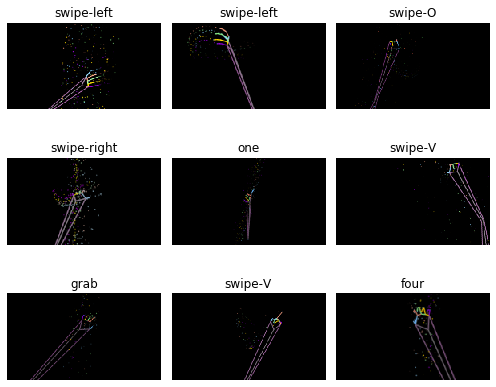

In [19]:
data = create_dataset(bs, img_size) # 192x108

swipe-left torch.Size([1080, 1920])
swipe-O torch.Size([1080, 1920])
four torch.Size([1080, 1920])
three torch.Size([1080, 1920])
grab torch.Size([1080, 1920])
three torch.Size([1080, 1920])
expand torch.Size([1080, 1920])
two torch.Size([1080, 1920])
swipe-right torch.Size([1080, 1920])
pinch torch.Size([1080, 1920])
swipe-left torch.Size([1080, 1920])
swipe-O torch.Size([1080, 1920])


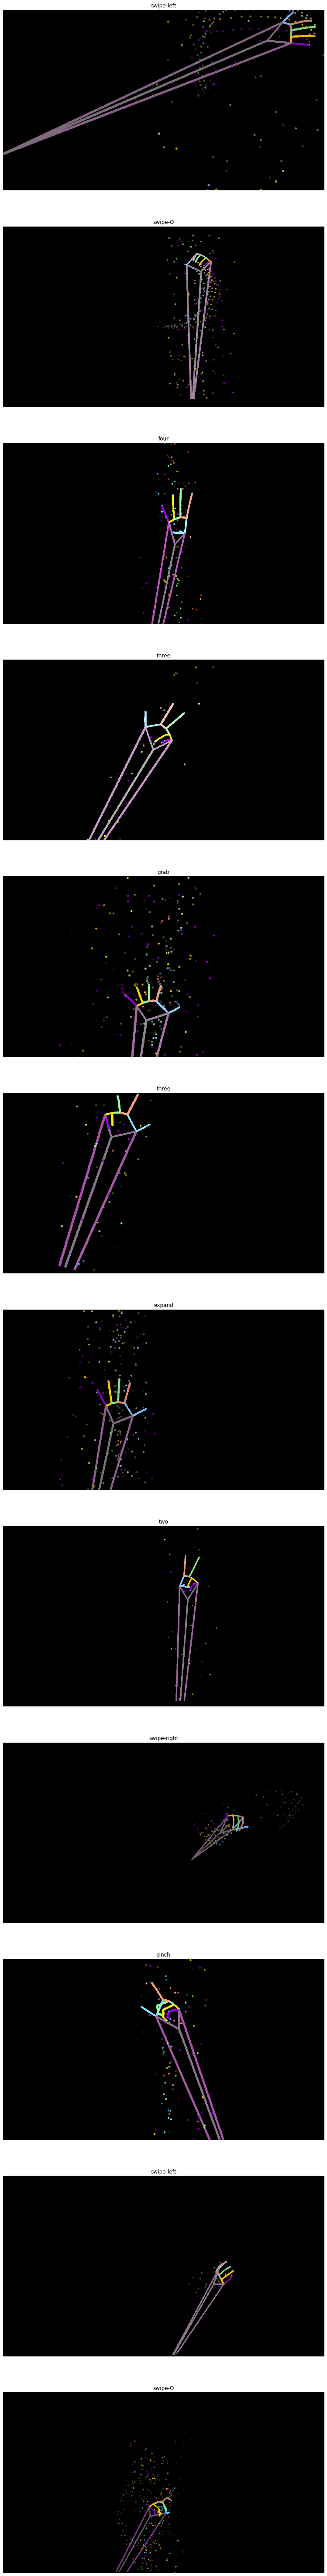

In [20]:
plot_random_augmented_image(data, 12, 1, 192, 108, size=(1080, 1920))

Batch  shape: torch.Size([64, 3, 108, 192])
Image  shape: torch.Size([3, 108, 192])
Labels shape: torch.Size([64])
Label[0]: 8 -> swipe-left
Label[2]: 11


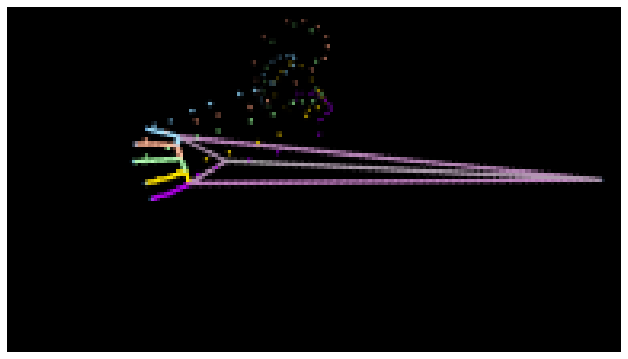

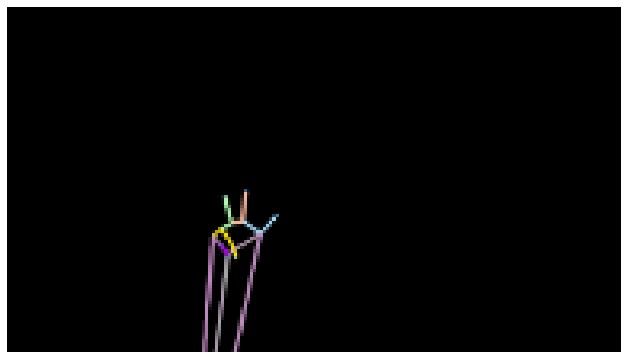

In [21]:
show_augmented_images()

In [22]:
from datetime import datetime
currtime = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

runtime_name = 'local'

if runtime_name   == 'local':
  savepath           = dataset_dir / '..' / 'models'
elif runtime_name == 'colab':
  savepath           = Path(base_path) / dataset_dir / 'models'
else:
  savepath           = Path('/tmp')

savepath.mkdir(exist_ok=True)

model_name = arch_str

print(f'Models will be saved at: {savepath} with name: {model_name}')

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))

learn = cnn_learner(data, cnn_model, metrics=accuracy)

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
print('Learner ready.')

Models will be saved at: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models with name: resnet-50
nvidia-smi memory usage/increment: [1138, 1127]
nvidia-smi memory usage/increment: [1194, 67]
Learner ready.


## Reload the previously trained v2.4 model to perform transfer learning from that

In [23]:
# resnet-50-img_size-540-960-4a-2020-02-25_11.05.03_8.pth
#model_frozen_letter = 'a'
#modelstr = model_name + '-img_size-' + '-'.join(str(x) for x in img_size) + '-' + str(train_round) + model_frozen_letter + '-' + currtime
#best_model = reload_best_model(Path('/mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/models'), modelstr, True)

def reload_a_model_with_different_number_of_classes(learner_obj, no_of_saved_model_classes, model_fname_to_load, debug=False):
    # https://forums.fast.ai/t/how-to-remove-the-last-fully-connected-layer-from-a-cnn-in-fastai-to-stack-more-than-one-cnn-into-a-fc-nn/26438
    # learn.model = nn.Sequential(*list(children(learn.model))[:-1], custom_head).
    print(f'The current problem has {len(learn.data.classes)} classes: {learn.data.classes}')
    # https://forums.fast.ai/t/transfer-learning-twice/43699/5
    # learn.model[-1][-1]=nn.Linear(in_features=512,out_features=5, bias=True)
    if debug:
        print(learner_obj.model)
        print(learner_obj.model[-1])
        print(learner_obj.model[-1][-1])
    print(f'Replacing the old head with {len(learn.data.classes)} neurons with a new one with {no_of_saved_model_classes} neurons...')
    learner_obj.model[-1][-1] = nn.Linear(in_features=512, out_features=no_of_saved_model_classes, bias=True)
    if debug:
        print(learner_obj.model[-1])
    print(f'Trying to reload a model with {no_of_saved_model_classes} classes...')
    learner_obj.load(model_fname_to_load, device=torch.cuda.current_device())
    if debug:
        print(learner_obj.model[-1])
    print(f'Replacing the new head with {no_of_saved_model_classes} neurons with another one with {len(learn.data.classes)} neurons...')
    learner_obj.model[-1][-1] = nn.Linear(in_features=512, out_features=len(learn.data.classes), bias=True).cuda()
    if debug:
        print(learner_obj.model[-1])
    return

load_path = Path('/mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/models')
model_fname_to_load = load_path / str(model_name + '-img_size-540-960-4a-2020-02-25_11.05.03_8')
reload_a_model_with_different_number_of_classes(learn, 16, model_fname_to_load)

learn.path = savepath # don't forget this if you want to be able to conclude an epoch with data from a read-only directory!
learn.data = data     # change the old data (if any) with the current dataset
print(f'Save path: {savepath}')

The current problem has 13 classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']
Replacing the old head with 13 neurons with a new one with 16 neurons...
Trying to reload a model with 16 classes...
Replacing the new head with 16 neurons with another one with 13 neurons...
Save path: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models


two torch.Size([1080, 1920])


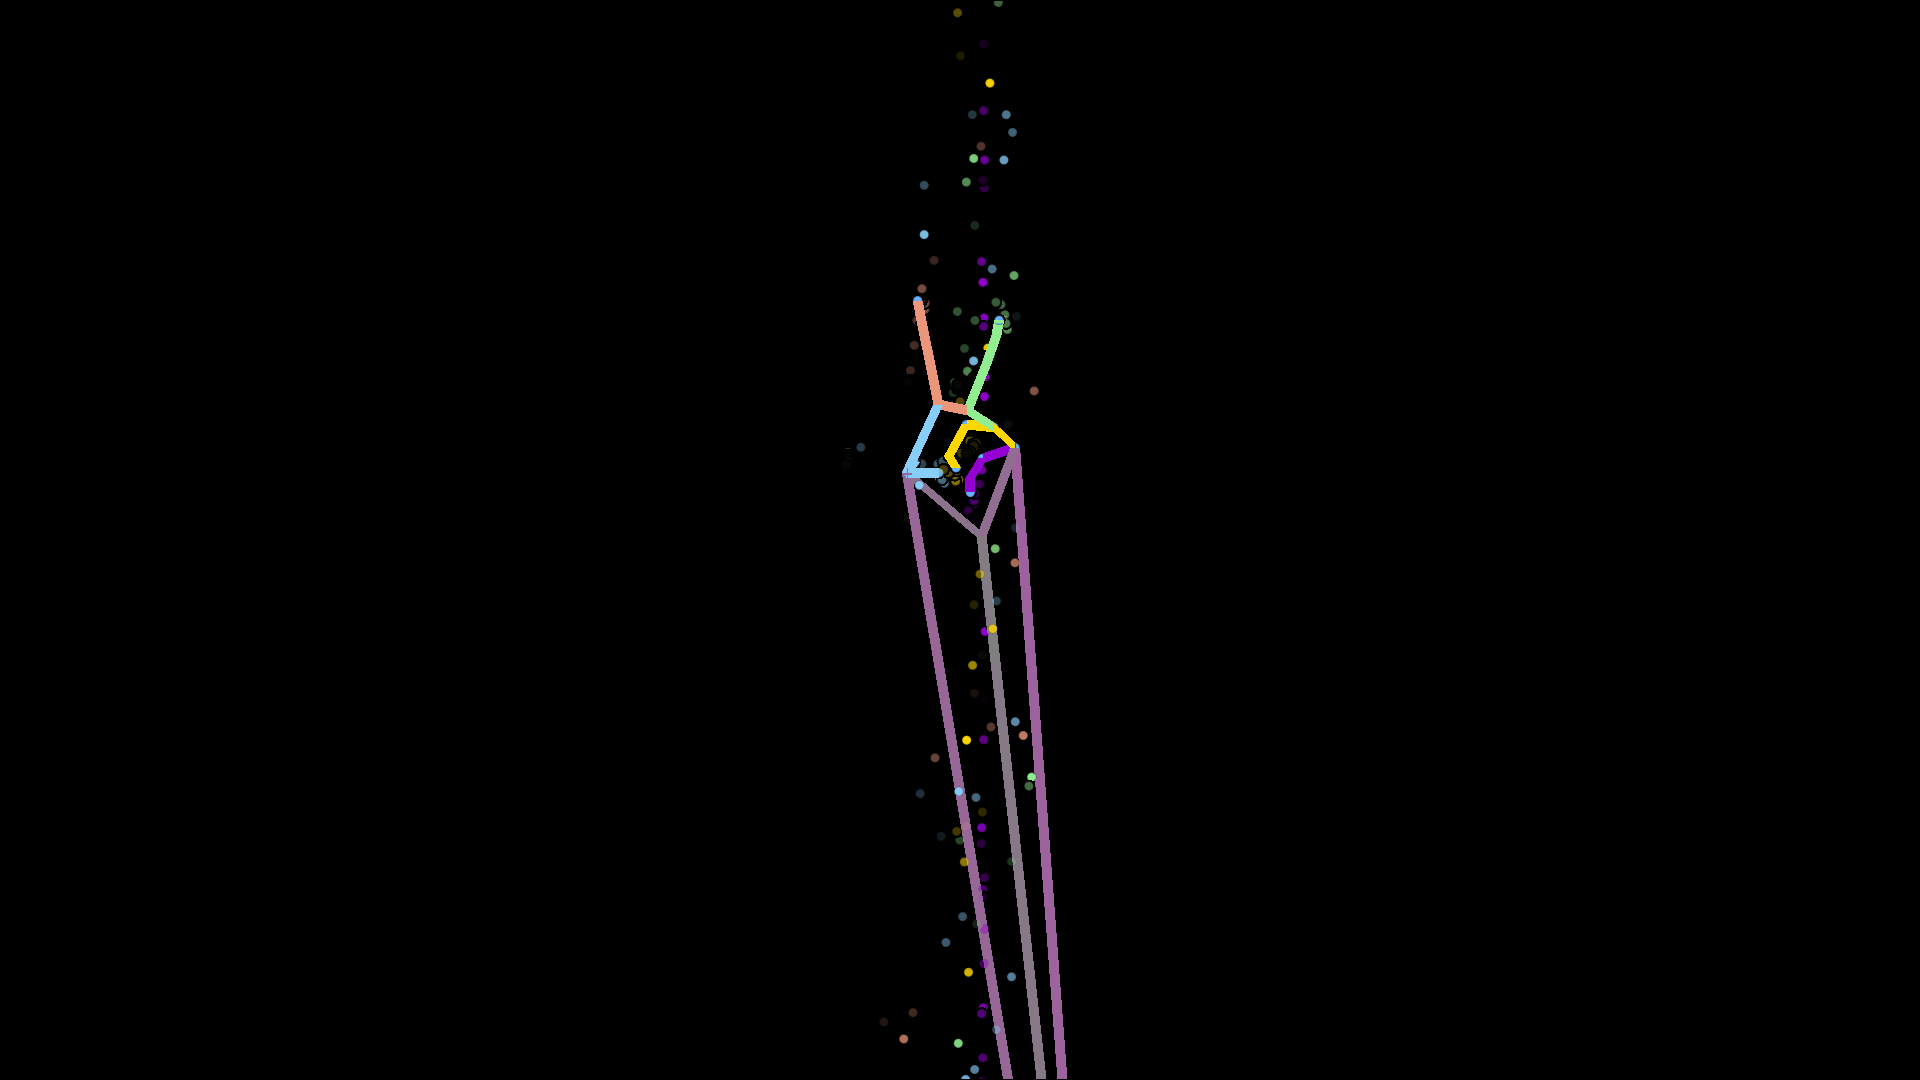

In [24]:
rnd_idx = np.random.randint(len(data.train_dl.dl.dataset.x))
img   = data.train_dl.dl.dataset.x[rnd_idx]
label = data.train_dl.dl.dataset.y[rnd_idx]
print(label, img.size)
img

one torch.Size([1080, 1920])


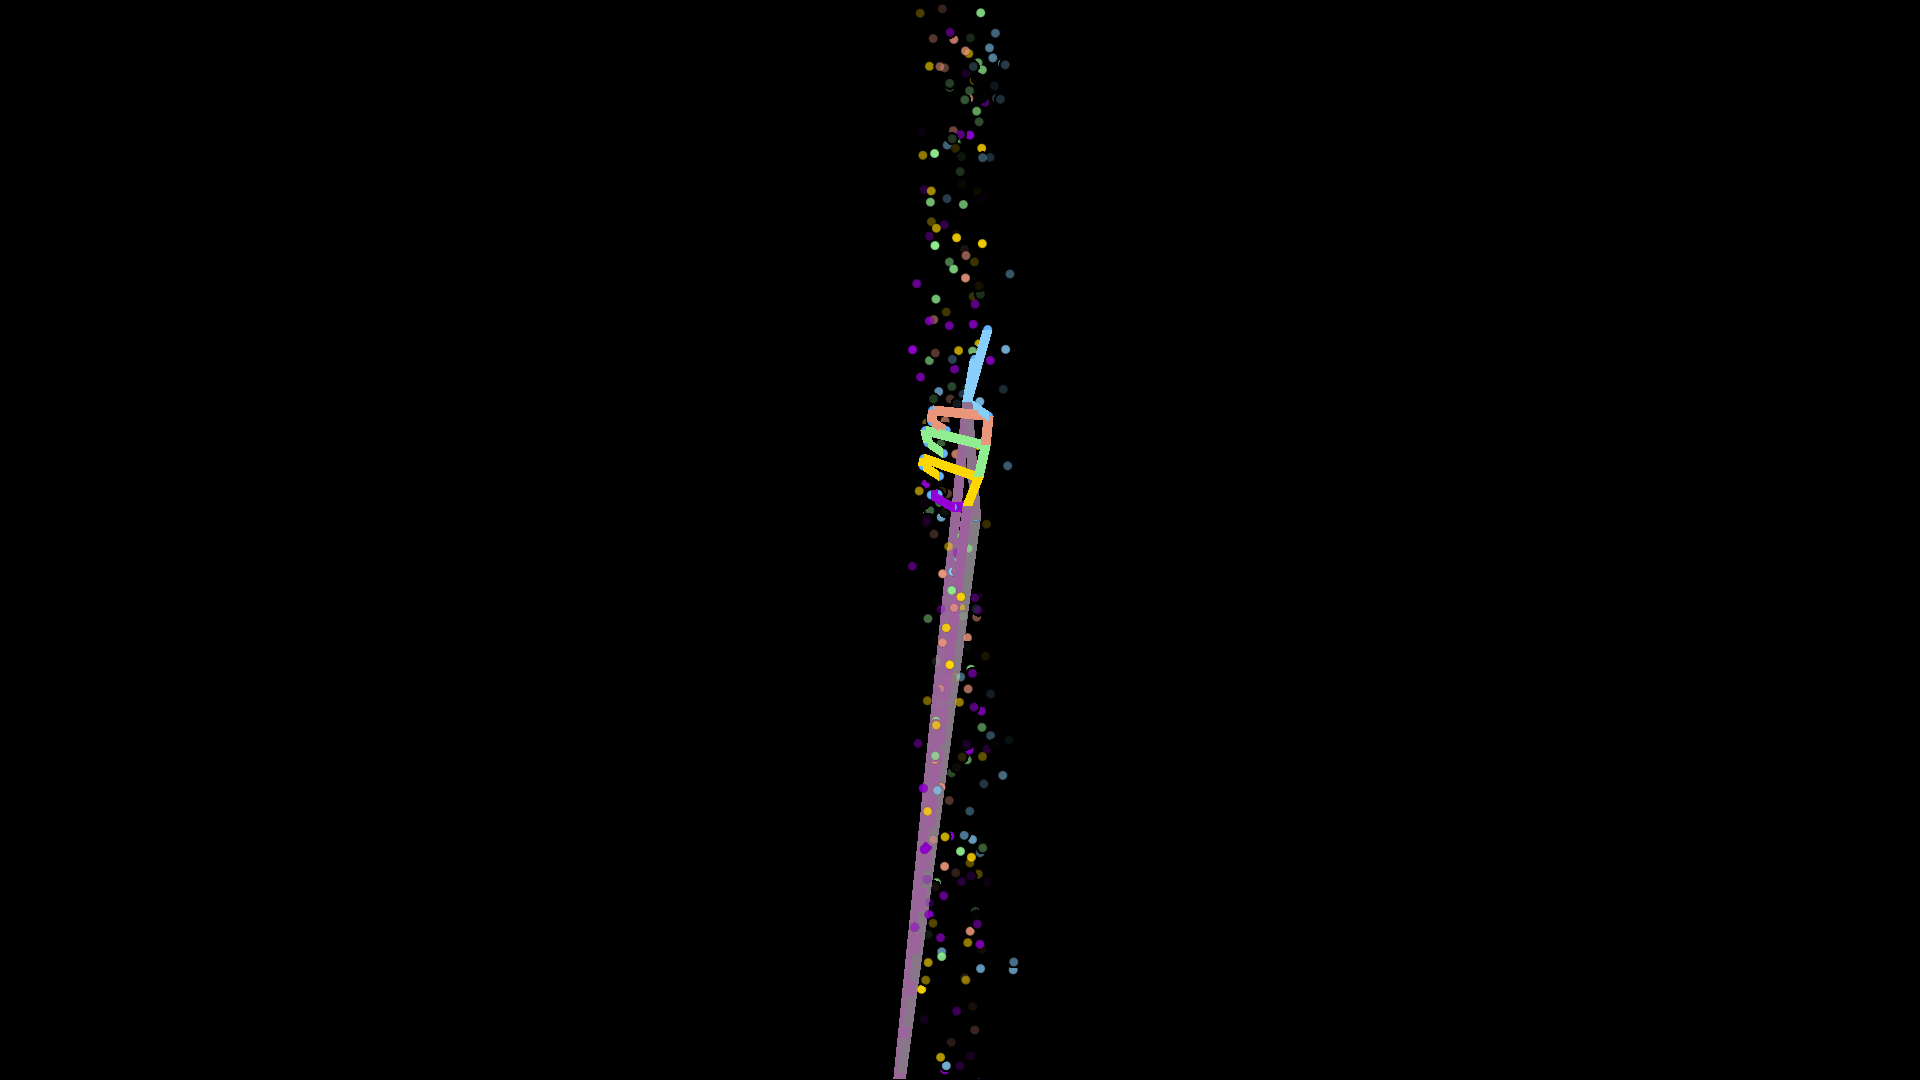

In [25]:
rnd_idx = np.random.randint(len(data.valid_dl.dl.dataset.x))
img   = data.valid_dl.dl.dataset.x[rnd_idx]
label = data.valid_dl.dl.dataset.y[rnd_idx]
print(label, img.size)
img

In [26]:
lr=1e-2

In [27]:
if runtime_name == 'colab':
    !bash -c 'if ! [ -d "/content/Ranger-Deep-Learning-Optimizer" ] ; then git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer ; cd Ranger-Deep-Learning-Optimizer ; ls -l ; pwd ; pip install -e . ; wget "https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py" ; else echo "/content/Ranger-Deep-Learning-Optimizer" already exists... ; fi'
!pip show ranger

Name: ranger
Version: 0.0.1
Summary: Ranger - a synergistic optimizer using RAdam (Rectified Adam) and LookAhead in one codebase 
Home-page: UNKNOWN
Author: Less Wright
Author-email: UNKNOWN
License: Apache
Location: /home/anonymous/Ranger-Deep-Learning-Optimizer
Requires: torch
Required-by: 


In [28]:
def show_hyperparams():
    print(f'Batch size: {bs}, image size: {img_size}, learning rate: {lr}')

In [29]:
def is_frozen(learn, debug=False):
    for child in learn.model.children():
        #print(child)
        for param in child.parameters():
            if debug:
                print(param.requires_grad)
            if param.requires_grad == False:
                return True, 'a'
    return False, 'b'

In [30]:
class SaveBestAccuracyCallback(TrackerCallback):
    "A `TrackerCallback` that stops the training when the accuracy reaches the desired level."
    def __init__(self, learn:Learner, save_str:str='best-accuracy-model'):
        super().__init__(learn, monitor='accuracy', mode='auto')
        self.prev_acc = 0.0
        self.save_str = save_str
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Check the monitored value and save the model if above prev_acc."
        current = self.get_monitor_value()
        print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
        if current is not None and self.operator(current, self.prev_acc):
            print(f'Accuracy {current} is above previous accuracy {self.prev_acc} at epoch {epoch}. Saving model...')
            self.prev_acc = current
            self.learn.save(f'{self.save_str}-acc-{current}-epoch-{epoch}')

In [31]:
def do_fit_fc(save_name, epochs=10, lr=defaults.lr, start_pct=0.3):
    savepath.mkdir(exist_ok=True)
    
    save_str = str(savepath) + '/' + model_name + '-img_size-' + '-'.join(str(x) for x in img_size) + '-' + save_name + '-' + currtime
    print(f'Learner object has path in: {learn.path} (which can be readonly, so we need to change it...)')
    learn.path = savepath
    print(f'Learner object new path is: {learn.path}')
    
    print(f'Saving models with prefix: {save_str}')
    
    reduce_lr_callback    = ReduceLROnPlateauCallback(learn, monitor='train_loss', patience=2, factor=0.2, min_delta=0)
    save_callback         = SaveModelCallback(learn, every='epoch', monitor='accuracy', name=save_str)
    #tracker_callback      = TrackerCallback(learn, monitor='feat_12')
    #stop_acc_callback     = StopAtThisAccuracyCallback(learn, value=0.999)
    save_best_callback    = SaveBestAccuracyCallback(learn, save_str=save_str)
    tensorboard           = None
    if tensorboard:
        tboard_callback   = LearnerTensorboardWriter(learn, base_dir=tboard_path, name=save_str)
    else:
        tboard_callback   = None

    #callbacks             = [save_callback, reduce_lr_callback, stop_acc_callback, save_best_callback, tboard_callback]
    callbacks             = [save_callback, reduce_lr_callback]
    
    learn.fit_fc(epochs, lr, start_pct=start_pct, callbacks=callbacks)
    learn.save(save_str)
    
    print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
    learn.show_results(rows=3)

In [32]:
def reload_best_model(savepath, modelstr, debug=False):
    if debug:
        print(modelstr)
   
    best_models = list(savepath.glob(modelstr + '*-acc-*.pth'))

    if debug:
        !ls -ltra {savepath}/{modelstr}*-acc-*.pth | tail -2
        print(best_models)
        
    best_models.sort()
    best_model  = str(best_models[-1]).replace('.pth', '')
    print(f'Reloading best model: {best_model}')
    learn.load(best_model)
    return best_model

# Fast.ai doesn't provide an `evaluate()`-like function as in Keras

![alt text](https://i.ibb.co/86k8rFN/image.png)

So it's not possible to have a labeled test set in the same databunch used for training/validation of the model. Ok, let's follow the advice and build another databunch with training and test set (used as validation set). <spoiler> In Keras there's a handy [model.evaluate()](https://keras.io/models/model/#evaluate) function to test the model. </spoiler>

In [33]:
def evaluate_model_from_interp(interp, data):
  # perform a "manual" evaluation of the model to take a look at predictions vs. labels and to
  # re-compute accuracy from scratch (to double check and also because I didn't find a quick way
  # to extract accuracy inside the guts of Fast.ai after a call to validate() on the test set...)
  print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
  print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
  print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)

  print('')
  print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')

  ok_pred = 0

  for idx, raw_p in enumerate(interp.preds):
      pred = np.argmax(raw_p)
      if idx < 100000:
          print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
      if pred == interp.y_true[idx]:
          ok_pred += 1

  acc = ok_pred / len(interp.y_true)
  print(f'Overall accuracy of the model: {acc:0.5f}')
  return acc

# Training

## Round 1 - 192x108px

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


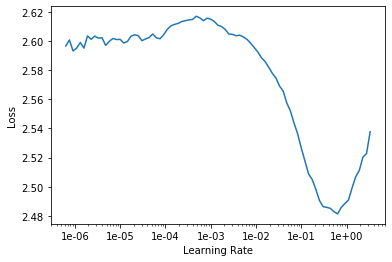

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
show_hyperparams()

Batch size: 64, image size: [108, 192], learning rate: 0.01


In [36]:
train_round=1
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Learner object has path in: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models (which can be readonly, so we need to change it...)
Learner object new path is: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models
Saving models with prefix: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models/resnet-50-img_size-108-192-1a-2020-04-21_15.47.18


nvidia-smi memory usage/increment: [3914, 3847]


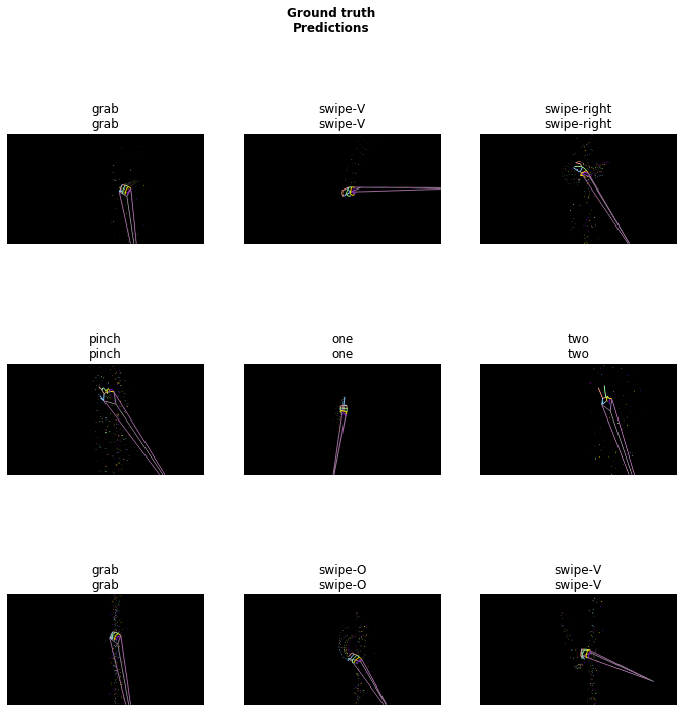

In [37]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Interpreting results and plotting top losses for stage-1


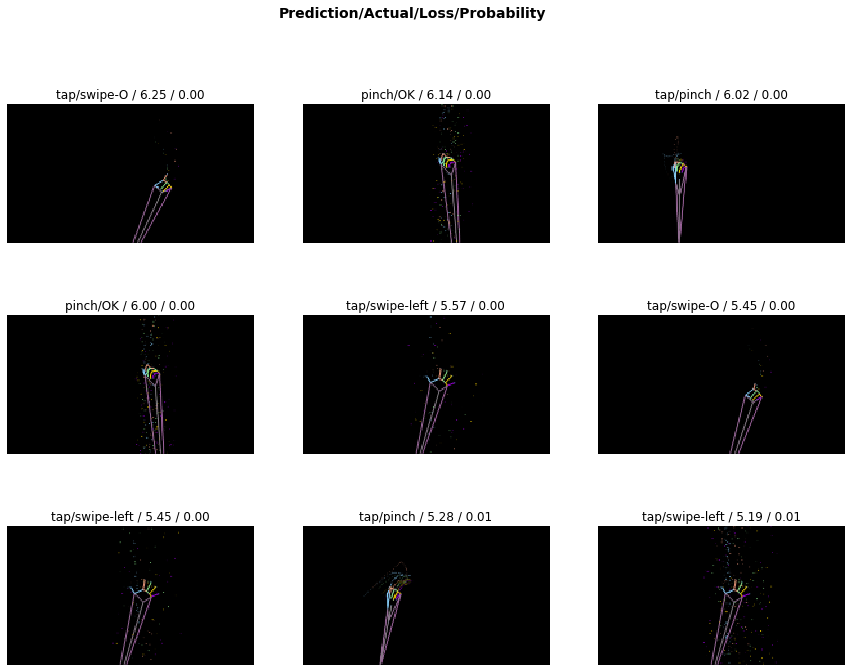

In [38]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-1


[('pinch', 'grab', 35),
 ('swipe-V', 'tap', 34),
 ('grab', 'pinch', 32),
 ('four', 'OK', 31),
 ('swipe-O', 'swipe-V', 31),
 ('pinch', 'expand', 23),
 ('swipe-V', 'swipe-O', 23),
 ('expand', 'pinch', 22),
 ('expand', 'grab', 16),
 ('grab', 'expand', 16),
 ('tap', 'expand', 15),
 ('swipe-O', 'tap', 14),
 ('two', 'grab', 12),
 ('tap', 'pinch', 11),
 ('swipe-V', 'grab', 10),
 ('OK', 'pinch', 9),
 ('OK', 'expand', 7),
 ('expand', 'tap', 7),
 ('pinch', 'tap', 7),
 ('swipe-V', 'swipe-right', 7),
 ('swipe-left', 'one', 7),
 ('swipe-right', 'grab', 7),
 ('tap', 'grab', 7),
 ('swipe-left', 'expand', 6),
 ('three', 'two', 6),
 ('four', 'tap', 5),
 ('grab', 'tap', 5),
 ('swipe-left', 'tap', 5),
 ('swipe-right', 'tap', 5),
 ('tap', 'swipe-right', 5),
 ('three', 'pinch', 5),
 ('two', 'three', 5),
 ('grab', 'swipe-right', 4),
 ('grab', 'three', 4),
 ('one', 'swipe-left', 4),
 ('swipe-O', 'grab', 4),
 ('swipe-V', 'two', 4),
 ('three', 'expand', 4),
 ('four', 'grab', 3),
 ('swipe-V', 'expand', 3),
 ('s

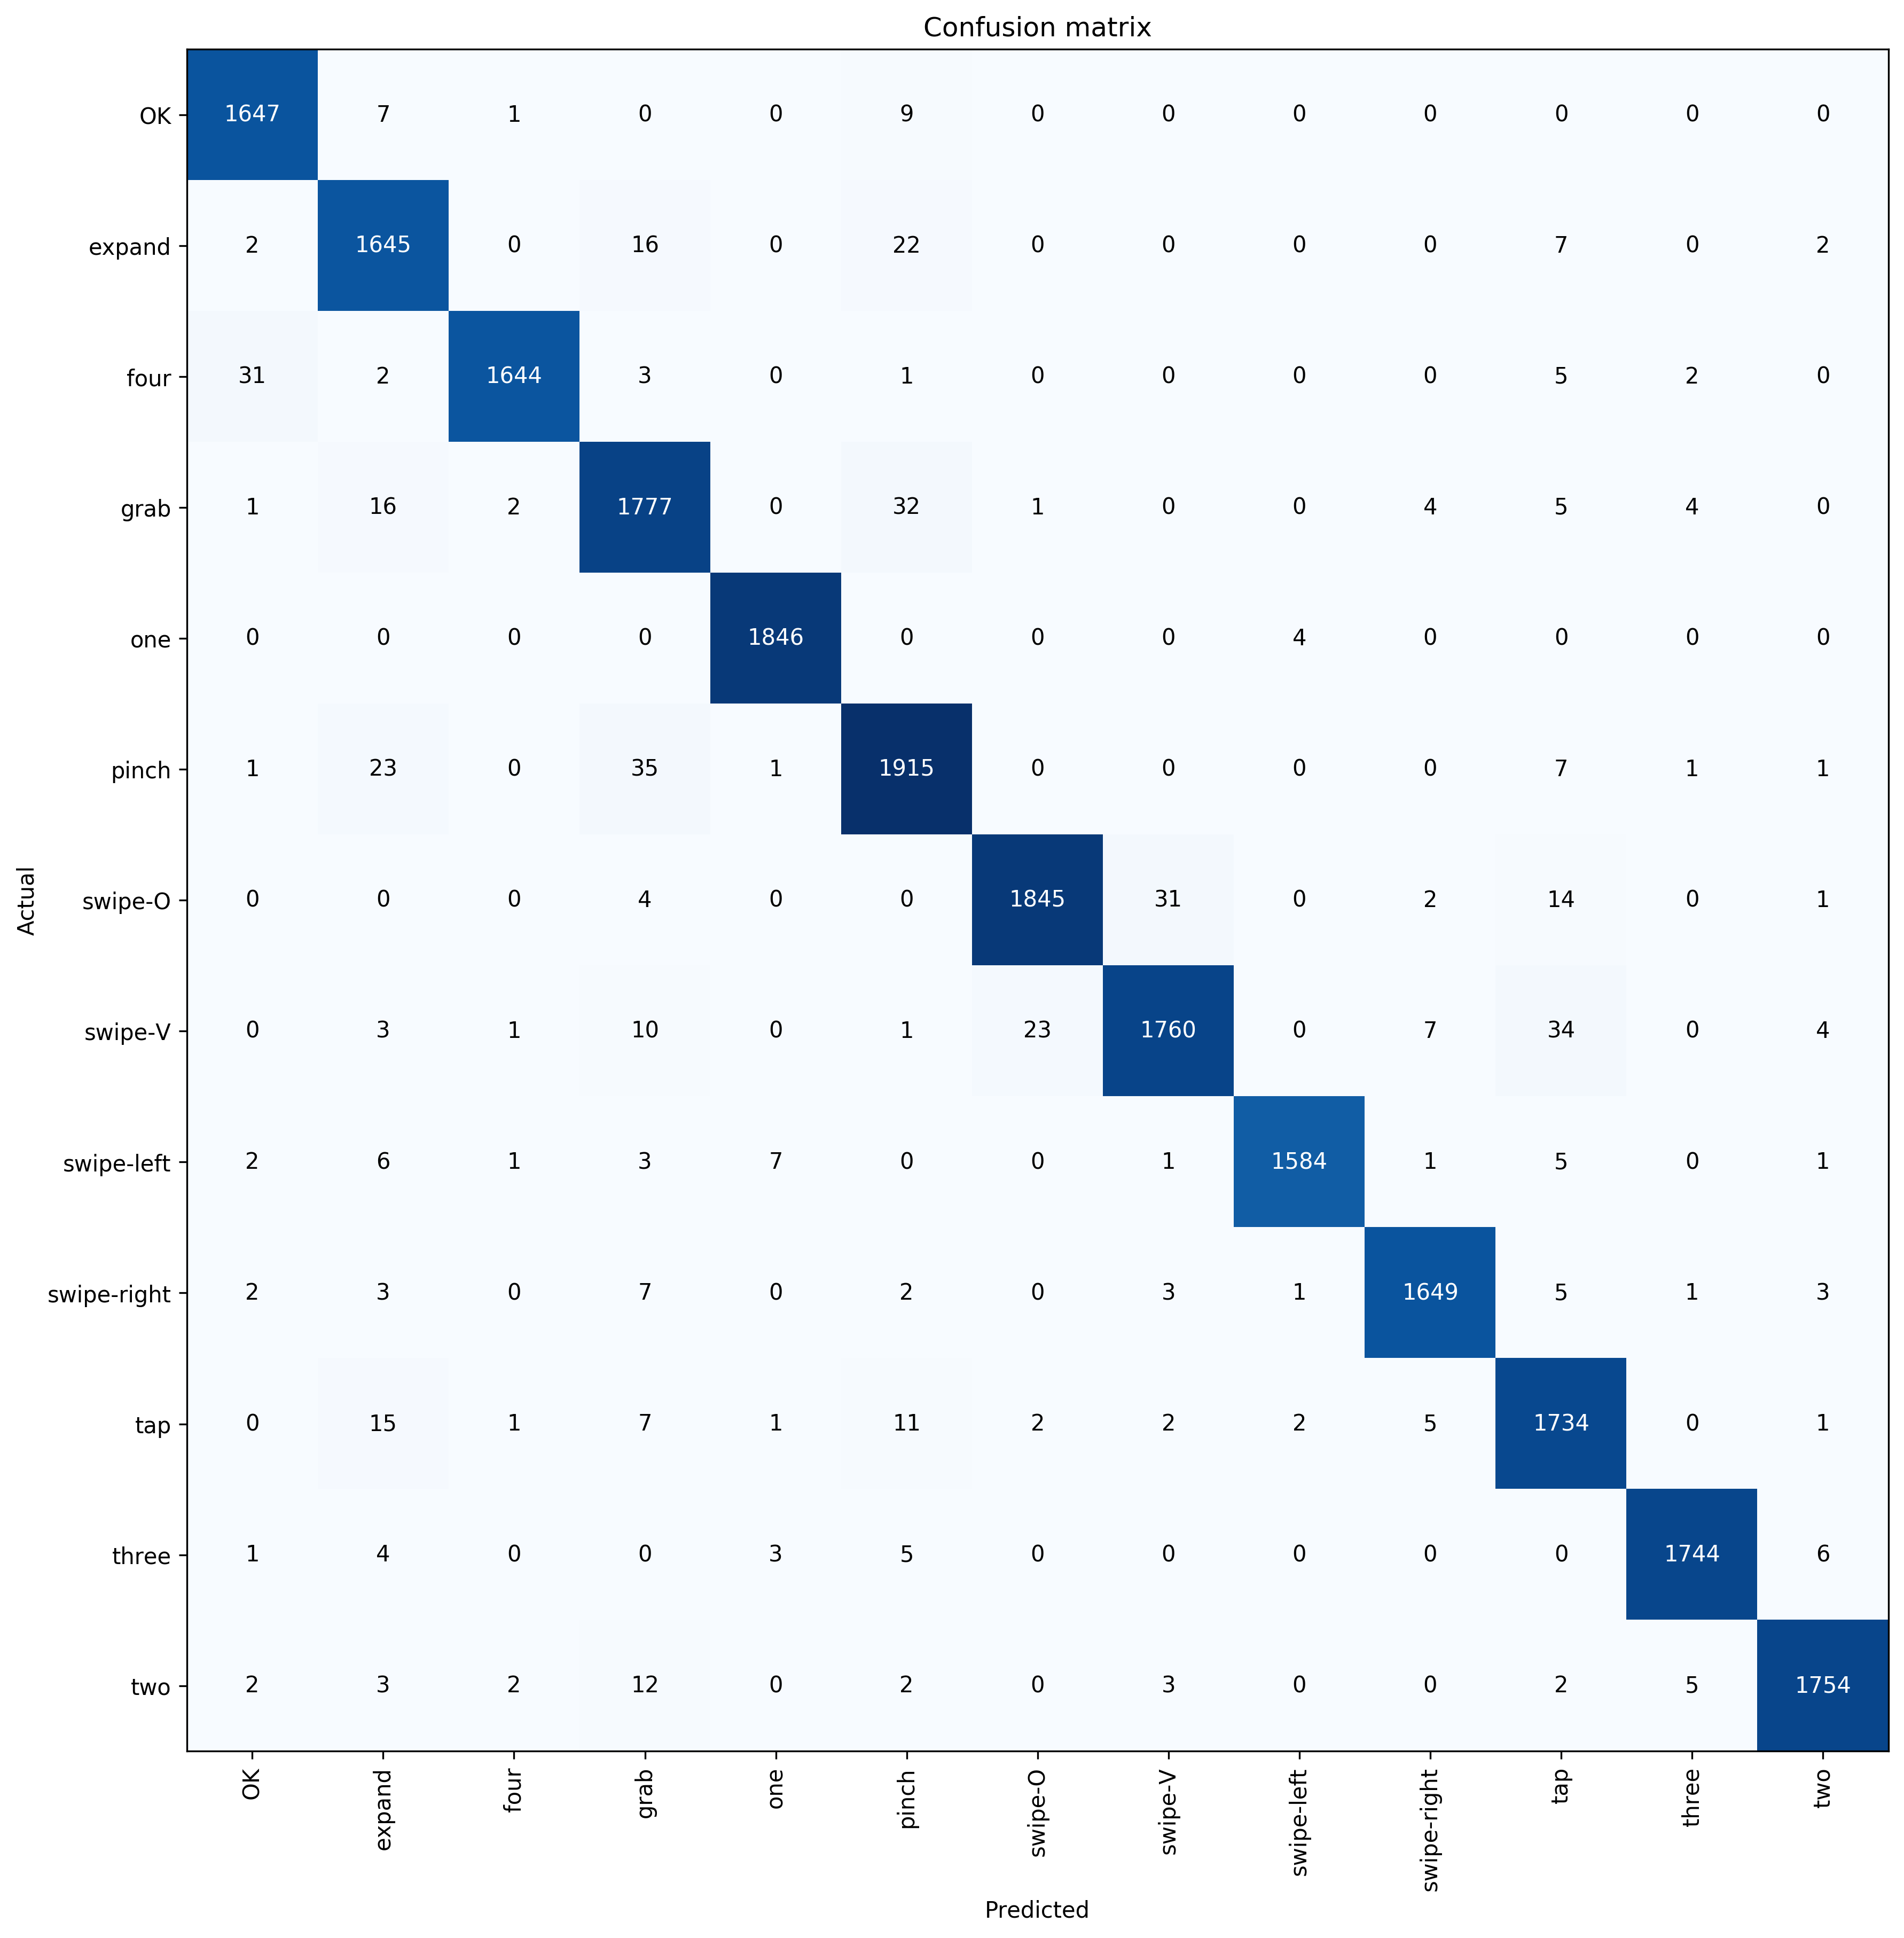

In [39]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-1


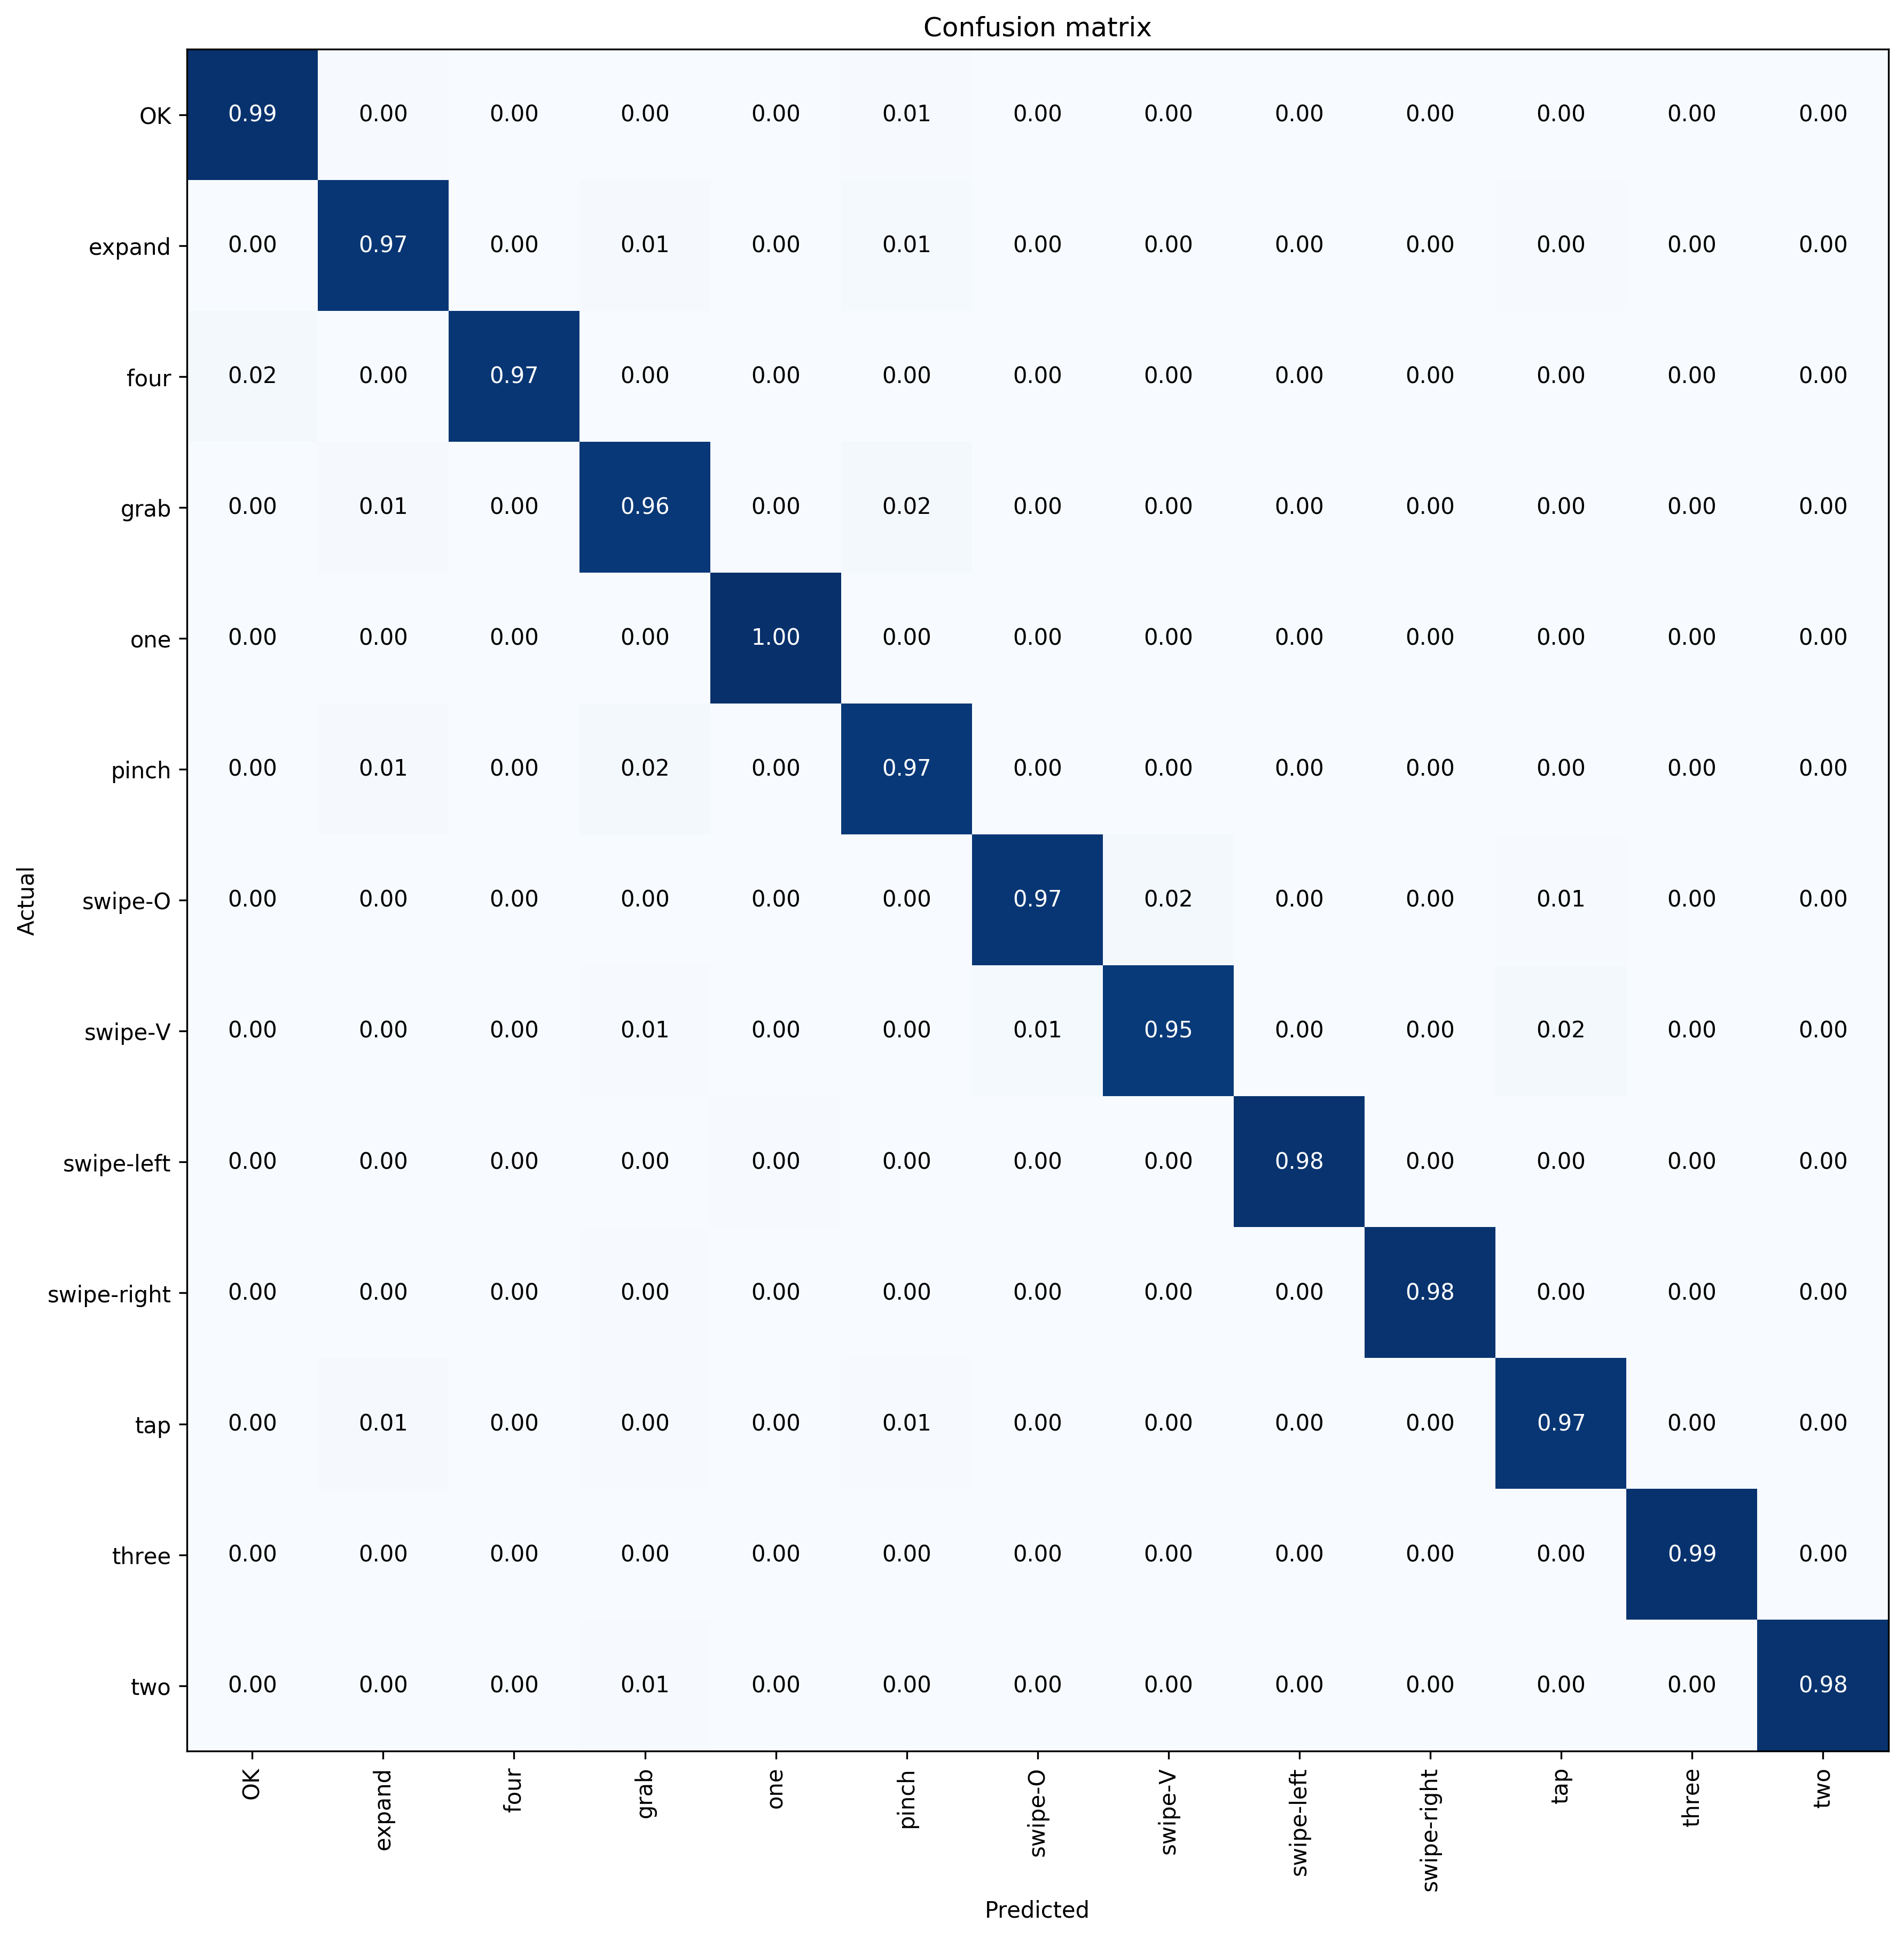

In [40]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [41]:
acc = evaluate_model_from_interp(interp, data)

Interp has 23078 ground truth labels: tensor([3, 7, 9,  ..., 5, 6, 5])
Interp yielded 23078 raw predictions. First two raw predictions are: tensor([[4.3695e-05, 4.1983e-04, 2.7987e-04, 9.9627e-01, 2.2103e-05, 1.4315e-03,
         1.6303e-06, 1.0114e-04, 2.0519e-05, 2.8729e-05, 1.2224e-04, 4.7105e-05,
         1.2135e-03],
        [2.2966e-04, 2.9465e-04, 3.5940e-04, 4.5342e-05, 7.1901e-04, 7.4763e-05,
         9.1887e-03, 9.7673e-01, 9.0918e-05, 1.4411e-03, 8.2767e-03, 5.5610e-04,
         1.9970e-03]])
The problem had 13 classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
12 -> 12 = two -> two
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
5 -> 3 = pinch -> grab
12 -> 12 = t

9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
4 -> 4 = one -> one
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
11 -> 11 = three -> three
2 -> 2 = four -> four
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
11 -> 11 = three -> three
2 -> 2 = four -> four
11 -> 11 = three -> three
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
4 -> 4 = one -> one
4 -> 4 = one -> one
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
12 -> 12 = two -> two
12 -> 12 = two -> two
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = gra

7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
1 -> 1 = expand -> expand
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
2 -> 2 = four -> four
12 -> 12 = two -> two
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
4 -> 4 = one -> one
12 -> 12 = two -> two
12 -> 12 = two -> two
2 -> 2 = four -> four
10 -> 10 = tap -> tap
2 -> 2 = four -> four
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
4 -> 4 = one -> one
3 -> 5 = grab -> pinch
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
10 -> 10 = tap -> tap
12 -> 12 = two -> two
4 -> 4 = one -> one
3 -> 3 = grab -> grab
11 -> 11 = three -> three
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
4 -> 4 = one -> one
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> s

9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
0 -> 0 = OK -> OK
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
2 -> 2 = four -> four
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
12 -> 12 = two -> two
10 -> 10 = tap -> tap
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
11 -> 11 = three -> three
2 -> 2 = four -> four
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
2 

8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
9 -> 10 = swipe-right -> tap
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
4 -> 4 = one -> one
1 -> 1 = expand -> expand
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
11 -> 1

9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
3 -> 3 = grab -> grab
12 -> 12 = two -> two
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
4 -> 4 = one -> one
11 -> 11 = three -> three
12 -> 12 = two -> two
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
4 -> 4 = one -> one
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
2 -> 2 = four -> four
12 -> 12 = two -> two
12 -> 12 = two -> two
3 -> 10 = grab -> tap
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
4 -> 4 = one -> one
10 -> 10 = tap -> tap
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
4 -> 4 = one -> one
2 -> 2 = four -> four
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
10 -> 7 = tap -> swipe-V
5 -> 5 = pinch -> pinch
9 -> 9 

7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
10 -> 7 = tap -> swipe-V
11 -> 11 = three -> three
3 -> 3 = grab -> grab
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
2 -> 2 = four -> four
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
12 -> 12 = two -> two
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
4 -> 4 = one 

6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
3 -> 5 = grab -> pinch
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
4 -> 4 = one -> one
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
2 -> 2 = four -> four
2 -> 2 = four -> four
12 -> 12 = two -> two
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
1 -> 1 

4 -> 4 = one -> one
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
2 -> 2 = four -> four
2 -> 2 = four -> four
7 -> 6 = swipe-V -> swipe-O
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
5 -> 3 = pinch -> grab
3 -> 3 = grab -> grab
4 -> 4 = one -> one
12 -> 12 = two -> two
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swip

1 -> 1 = expand -> expand
2 -> 2 = four -> four
4 -> 4 = one -> one
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
2 -> 2 = four -> four
2 -> 2 = four -> four
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
12 -> 12 = two -> two
4 -> 4 = one -> one
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
10 -

0 -> 0 = OK -> OK
2 -> 2 = four -> four
11 -> 11 = three -> three
11 -> 11 = three -> three
0 -> 0 = OK -> OK
2 -> 2 = four -> four
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
12 -> 12 = two -> two
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
5 -> 5 =

6 -> 7 = swipe-O -> swipe-V
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
3 -> 3 = grab -> grab
4 -> 4 = one -> one
11 -> 11 = three -> three
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
4 -> 4 = one -> one
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
0 -> 2 = OK -> four
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
0 -> 0 = OK -> OK
4 -> 4 = one -> one
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
10 -> 7 = tap -> swipe-V
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
4 -> 4 = one -> one
4 -> 4 = one -> one
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right 

8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
12 -> 12 = two -> two
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
4 -> 4 = one -> one
11 -> 11 = three -> three
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
11 -> 11 = three -> three
4 -> 4 = one -> one
0 -> 0 = OK -> OK
12 -> 12 = two -> two
12 -> 12 = two -> two
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
4 -> 4 = one -> one
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-l

10 -> 10 = tap -> tap
2 -> 2 = four -> four
3 -> 3 = grab -> grab
12 -> 12 = two -> two
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
2 -> 2 = four -> four
4 -> 4 = one -> one
0 -> 0 = OK -> OK
2 -> 2 = four -> four
10 -> 10 = tap -> tap
3 

2 -> 2 = four -> four
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
5 -> 3 = pinch -> grab
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
4 -> 4 = one -> one
3 -> 3 = grab -> grab
11 -> 11 = three -> three
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
0 -> 0 = OK -> OK
4 -> 4 = one -> one
1 -> 1 = expand -> expand
2 -> 2 = four -> four
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
6 -> 6 

4 -> 4 = one -> one
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
2 -> 2 = four -> four
2 -> 2 = four -> four
4 -> 4 = one -> one
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
0 -> 0 = OK -> OK
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
4 -> 4 = one -> one
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
2 -> 2 = four -> four
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
8 

4 -> 4 = one -> one
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
4 -> 4 = one -> one
0 -> 0 = OK -> OK
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
4 -> 4 = one -> one
1 -> 1 = expand -> expand
4 -> 4 = one -> one
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
6 -> 10 = swipe-O -> tap
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
12 -> 12 = two -> two
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> t

11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
4 -> 4 = one -> one
2 -> 2 = four -> four
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
11 -> 11 = three -> three
12 -> 12 = two -> two
12 -> 12 = two -> two
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
2 -> 2 = four -> four
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
2 -> 2 = four -> four
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
0 -> 9 = OK -> swipe-right
2 -> 2 = four -> four
3 -> 3 = grab -> grab
12 -> 12 = two -> two
2 -> 2 = four

1 -> 1 = expand -> expand
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
2 -> 2 = four -> four
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
2 -> 2 = four -> four
0 -> 0 = OK -> OK
2 -> 2 = four -> four
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
11 -> 11 = three -> three
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
4 -> 4 = one -> one
4 -> 4 = one -> one
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK


4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
4 -> 4 = one -> one
4 -> 8 = one -> swipe-left
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
1 -> 11 = expand -> three
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
4 -> 4 = one -> one
12 -> 12 = two -> two
9 -> 9 = swipe-

5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
12 -> 12 = two -> two
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
3 -> 5 = grab -> pinch
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
2 -> 2 = four -> four
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
5 -> 5 = pinc

2 -> 2 = four -> four
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
2 -> 2 = four -> four
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
2 -> 2 = four -> four
11 -> 11 = three -> three
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
7 -> 12 = swipe-V -> two
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
7

10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
2 -> 2 = four -> four
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
2 -> 2 = four -> four
3 -> 3 = grab -> grab
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
12 -> 12 = two -> two
4 -> 4 = one -> one
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
5 -> 5 = pin

0 -> 0 = OK -> OK
2 -> 2 = four -> four
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
12 -> 12 = two -> two
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
12 -> 12 = two -> two
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
1 -> 5 = expand -> pinch
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
4 -> 4 = one -> one
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
0 -> 2 = OK -> four
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
0 -> 0 = 

6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
4 -> 4 = one -> one
11 -> 11 = three -> three
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
10 -> 6 = tap -> swipe-O
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
1 -> 5 = expand -> pinch
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -

4 -> 4 = one -> one
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
1 -> 5 = expand -> pinch
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
3 -> 5 = grab -> pinch
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
12 -> 12 = two -> two
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-ri

9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
11 -> 11 = three -> three
11 -> 11 = three -> three
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
4 -> 4 = one -> one
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
4 -> 4 = one -> one
11 -> 11 = three -> three
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = s

4 -> 4 = one -> one
11 -> 11 = three -> three
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
12 -> 12 = two -> two
11 -> 11 = three -> three
2 -> 2 = four -> four
4 -> 4 = one -> one
11 -> 11 = three -> three
3 -> 3 = grab -> grab
12 -> 12 = two -> two
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
12 -> 12 = two -> two
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
5 -> 5 = pinch -> pi

5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
0 -> 0 = OK -> OK
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
2 -> 2 = four -> four
3 -> 3 = grab -> grab
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
12 -> 12 = two -> two
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
11 -> 11 = three -> three
2 -> 2 = four -> four
11 -> 11 = three -> three
1 -> 1 = expand -> expand
4 -> 4 = one -> one
11 -> 11 = three -> three
7 -> 7 = swipe-V -> 

1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
3 -> 3 = grab -> grab
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
12 -> 11 = two -> three
1 -> 1 = expand -> expand
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V


5 -> 5 = pinch -> pinch
7 -> 6 = swipe-V -> swipe-O
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
12 -> 12 = two -> two
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
1 -> 3 = expand -> grab
11 -> 11 = three -> three
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
2 -> 2 = four ->

9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left ->

1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
0 -> 0 = OK -> OK
4 -> 4 = one -> one
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
12 -> 12 = two -> two
12 -> 12 = two -> two
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
2 -> 2 = four -> four
10 -> 10 = tap -> tap
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
11 -> 11 = t

6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
12 -> 12 = two -> two
12 -> 12 = two -> two
4 -> 4 = one -> one
10 -> 10 = tap -> tap
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
4 -> 4 = one -> one
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
4 -> 4 = one -> one
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
8 -> 8 = swipe-left ->

9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
12 -> 12 = two -> two
2 -> 2 = four -> four
1 -> 1 = expand -> expand
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swi

9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
1 -> 1 = expand -> expand
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
3 -> 3 = grab -> grab
4 -> 4 = one -> one
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
4 -> 4 = one -> one
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
12 -> 12 = two -> two
11 -> 11 = three -> three
3 -> 3 = grab -> grab
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
7 ->

## Round 2 - 384x216px

The dataset has 13 (13) classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']
Training   set len is: (x: 53851, y: 53851)
Validation set len is: (x: 23078, y: 23078)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


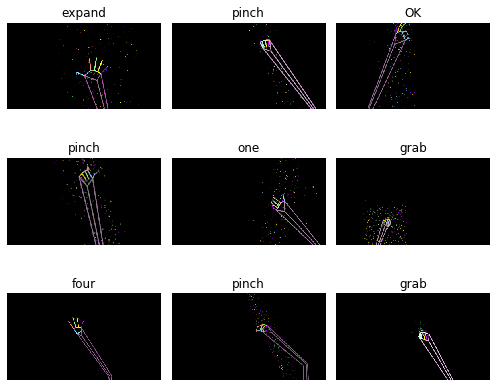

In [42]:
bs=64
img_size=[int(x/5) for x in default_size] # 384x216
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([64, 3, 216, 384])
Image  shape: torch.Size([3, 216, 384])
Labels shape: torch.Size([64])
Label[0]: 10 -> tap
Label[2]: 10


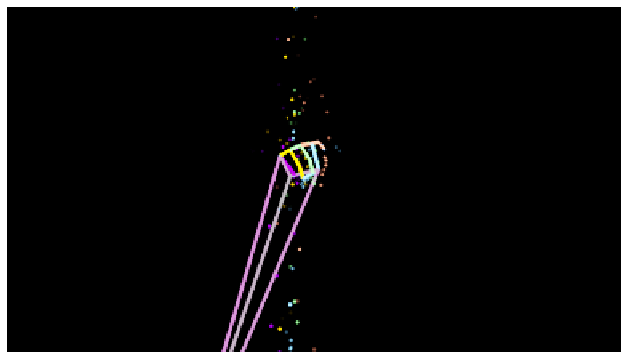

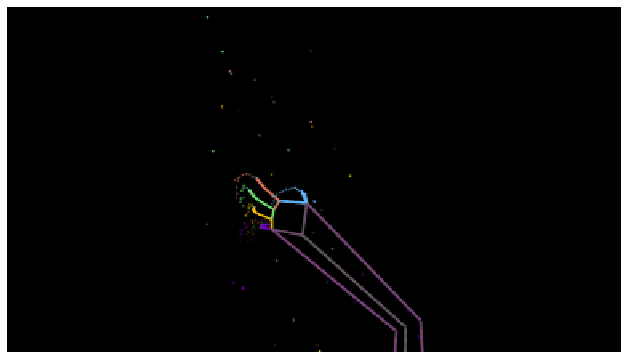

In [43]:
show_augmented_images()

In [44]:
show_hyperparams()

Batch size: 64, image size: [216, 384], learning rate: 0.01


In [45]:
train_round=2
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


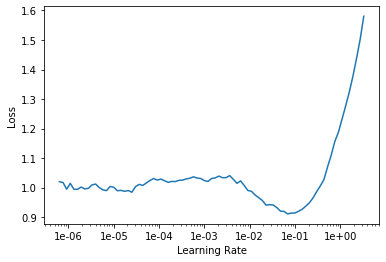

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
lr=1e-2

Learner object has path in: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models (which can be readonly, so we need to change it...)
Learner object new path is: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models
Saving models with prefix: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models/resnet-50-img_size-216-384-2a-2020-04-21_15.47.18


nvidia-smi memory usage/increment: [11788, 7941]


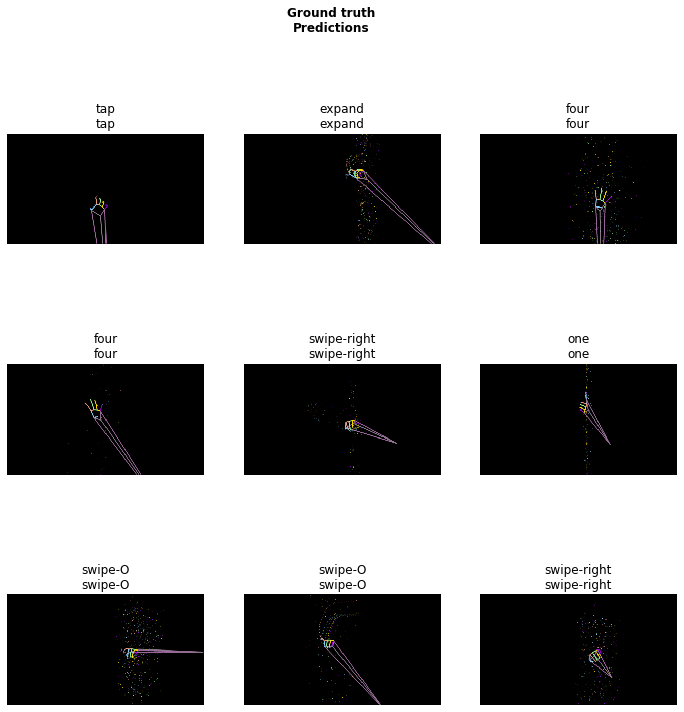

In [48]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

## Round 3 - 576x324px

The dataset has 13 (13) classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']
Training   set len is: (x: 53851, y: 53851)
Validation set len is: (x: 23078, y: 23078)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


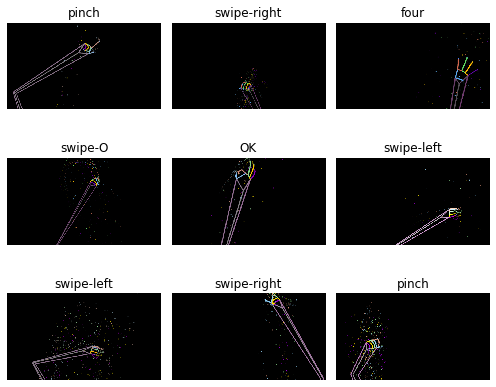

In [49]:
bs=64
img_size=[int(x/10*3) for x in default_size] # 576x324
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([64, 3, 324, 576])
Image  shape: torch.Size([3, 324, 576])
Labels shape: torch.Size([64])
Label[0]: 6 -> swipe-O
Label[2]: 3


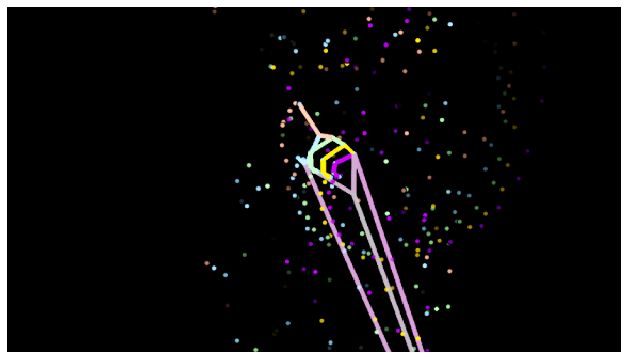

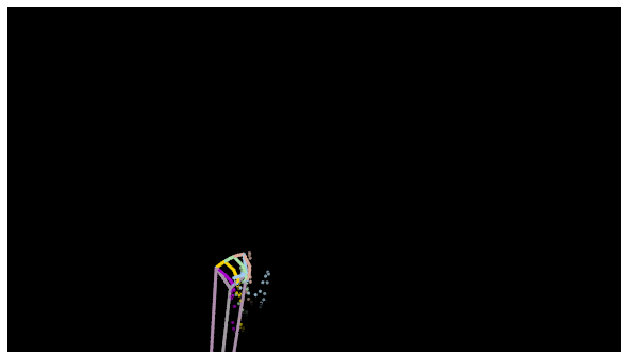

In [50]:
show_augmented_images()

In [51]:
show_hyperparams()

Batch size: 64, image size: [324, 576], learning rate: 0.01


In [52]:
train_round=3
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


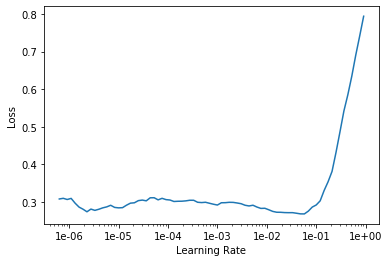

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
lr=1e-2

Learner object has path in: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models (which can be readonly, so we need to change it...)
Learner object new path is: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models
Saving models with prefix: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models/resnet-50-img_size-324-576-3a-2020-04-21_15.47.18


nvidia-smi memory usage/increment: [25554, 17613]


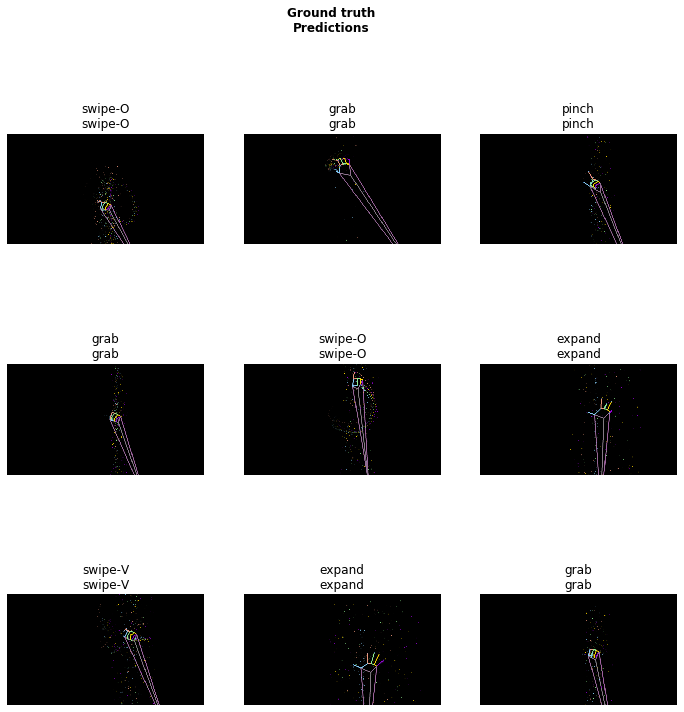

In [55]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

## Round 4 - 960x540px

The dataset has 13 (13) classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']
Training   set len is: (x: 53851, y: 53851)
Validation set len is: (x: 23078, y: 23078)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


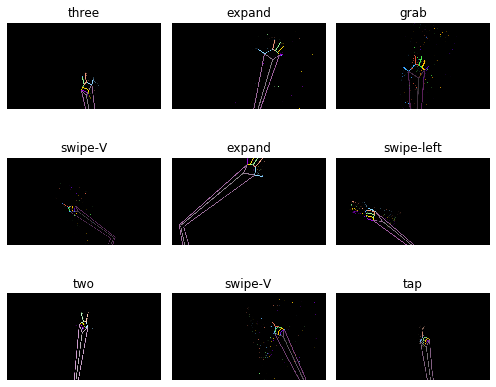

In [56]:
bs=16
img_size=[int(x/2) for x in default_size] # 960x540
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([16, 3, 540, 960])
Image  shape: torch.Size([3, 540, 960])
Labels shape: torch.Size([16])
Label[0]: 11 -> three
Label[2]: 3


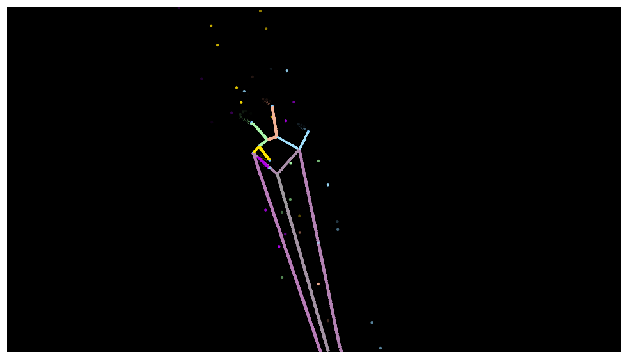

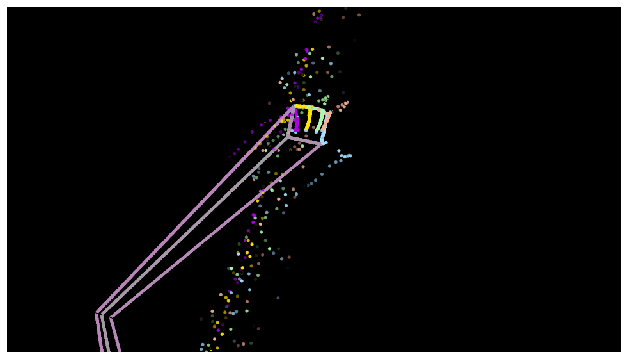

In [57]:
show_augmented_images()

In [58]:
show_hyperparams()

Batch size: 16, image size: [540, 960], learning rate: 0.01


In [59]:
train_round=4
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


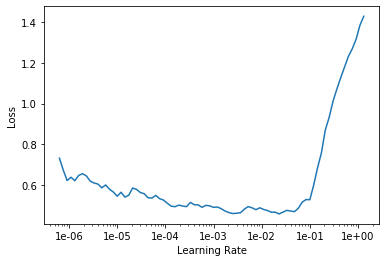

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
lr=1e-3

Learner object has path in: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models (which can be readonly, so we need to change it...)
Learner object new path is: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models
Saving models with prefix: /mnt/beegfs/home/anonymous/dataset/dynamic-hand-gestures-datasets/dynamic-hand-gestures-sfinge-3D-datasets/dataset-v2/../models/resnet-50-img_size-540-960-4a-2020-04-21_15.47.18


nvidia-smi memory usage/increment: [17874, 261]


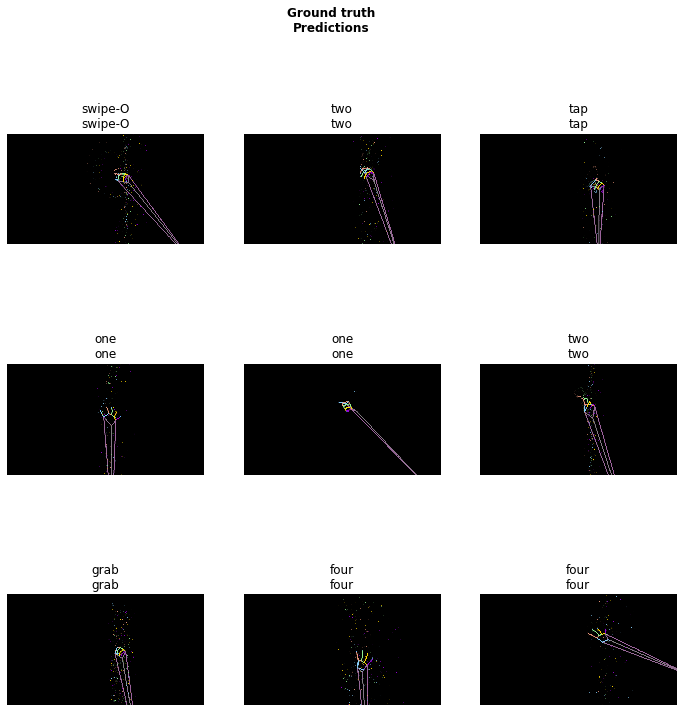

In [62]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Interpreting results and plotting top losses for stage-4


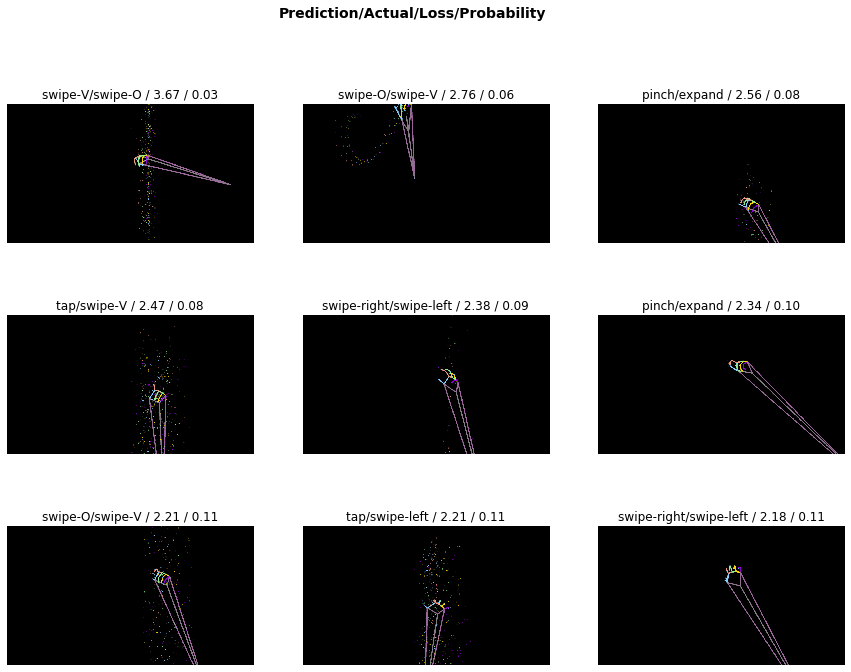

In [63]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-4


[('swipe-V', 'tap', 9),
 ('swipe-V', 'swipe-O', 8),
 ('swipe-O', 'swipe-V', 6),
 ('grab', 'pinch', 5),
 ('swipe-left', 'swipe-right', 5),
 ('tap', 'expand', 5),
 ('tap', 'swipe-O', 5),
 ('swipe-V', 'swipe-right', 4),
 ('tap', 'grab', 4),
 ('expand', 'pinch', 3),
 ('grab', 'swipe-right', 3),
 ('swipe-left', 'OK', 3),
 ('swipe-O', 'tap', 2),
 ('swipe-left', 'grab', 2),
 ('swipe-right', 'grab', 2),
 ('tap', 'swipe-V', 2)]

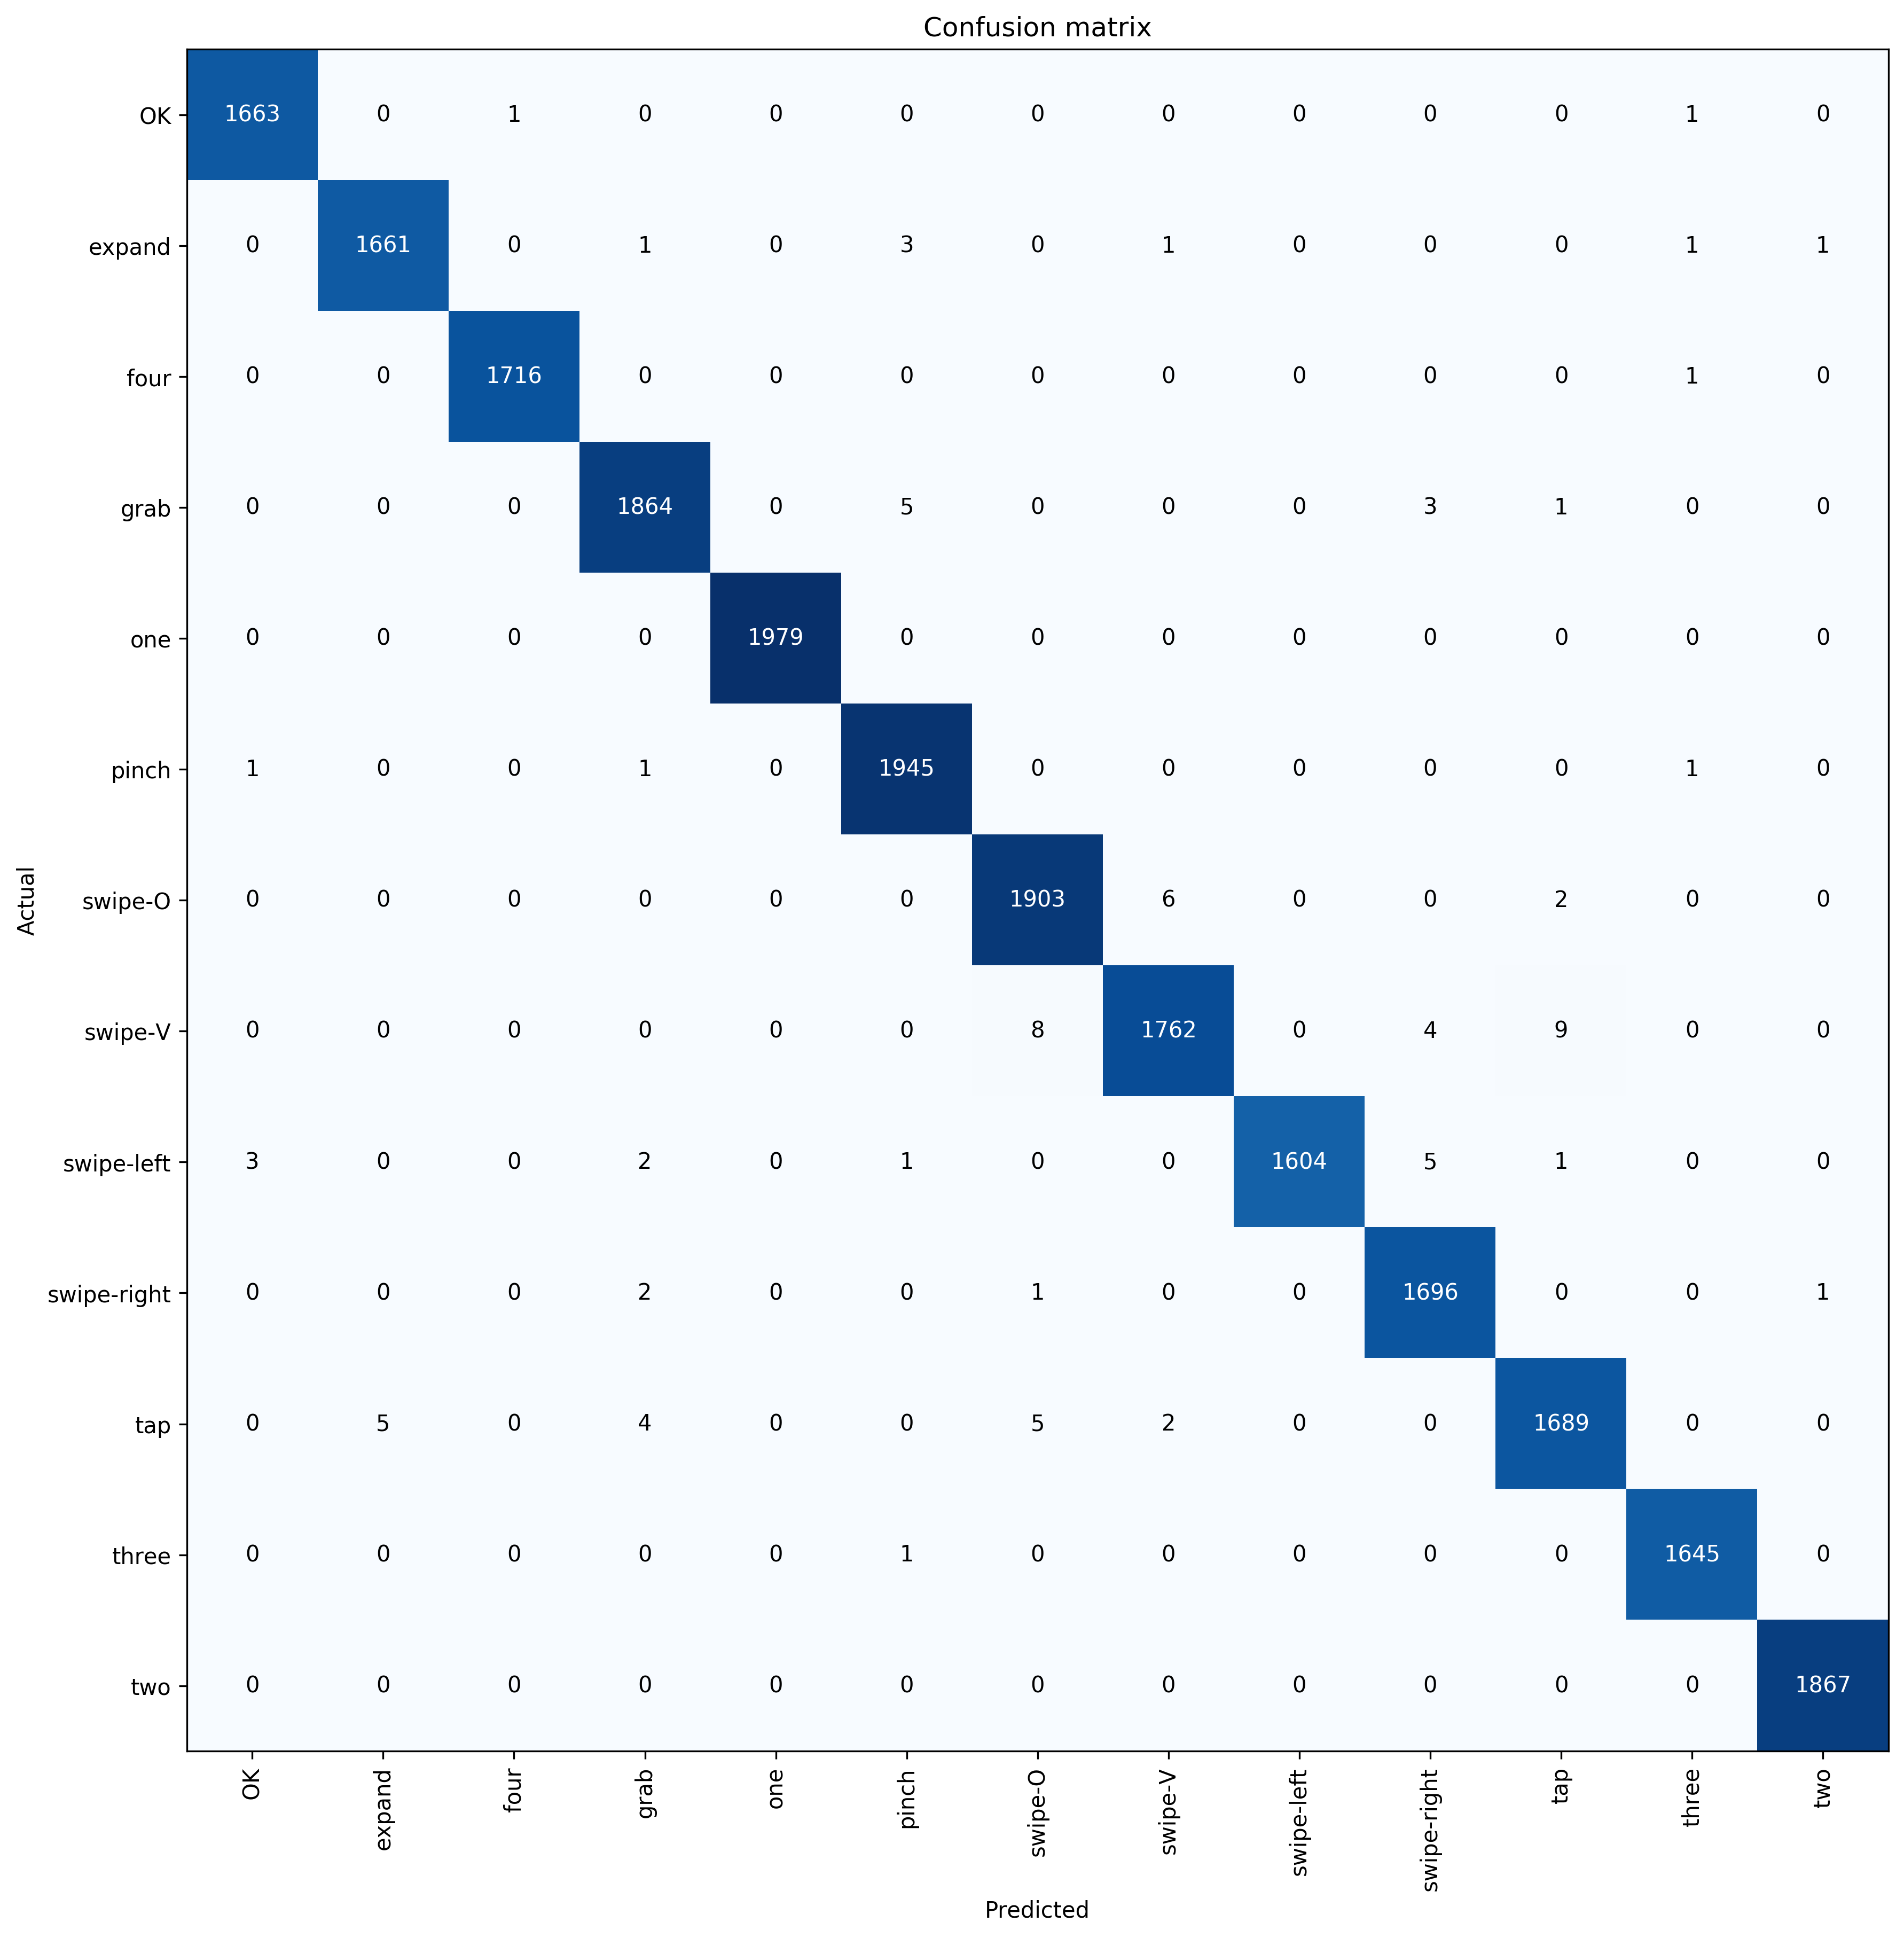

In [64]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-4


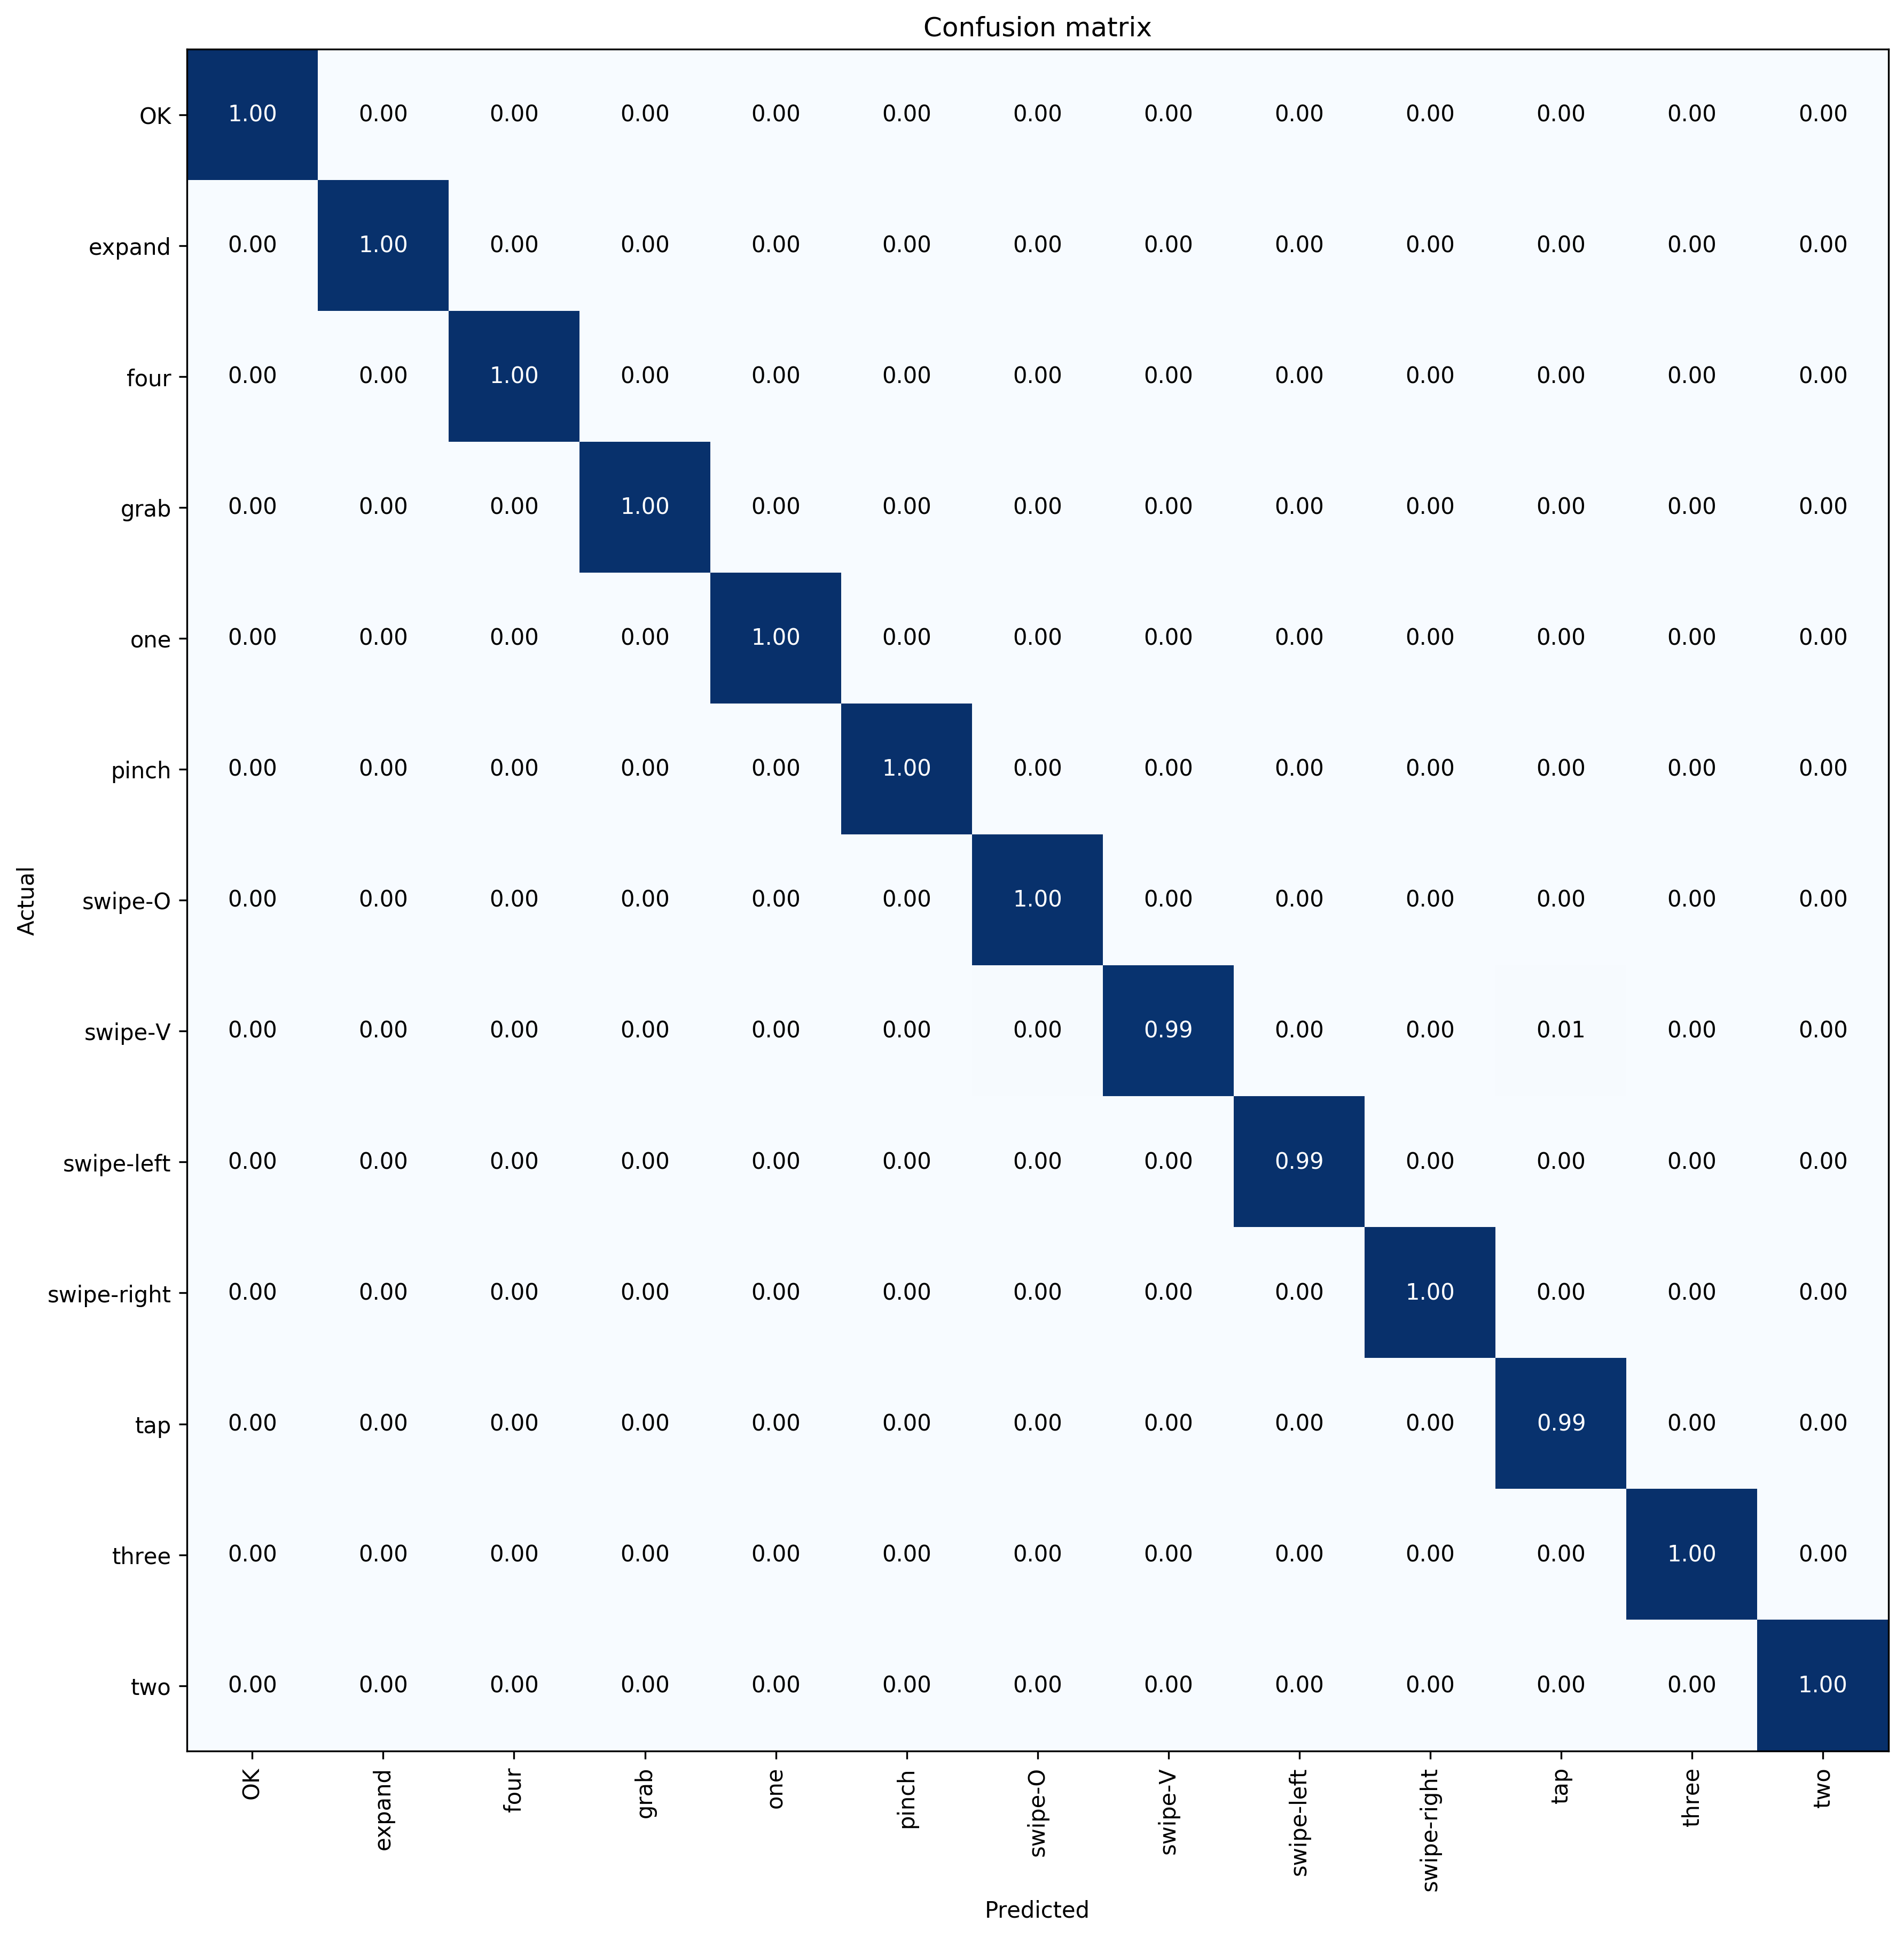

In [65]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [66]:
acc = evaluate_model_from_interp(interp, data)

Interp has 23078 ground truth labels: tensor([ 6, 12, 10,  ...,  2,  5,  6])
Interp yielded 23078 raw predictions. First two raw predictions are: tensor([[1.5825e-06, 5.3283e-06, 2.2232e-06, 5.2142e-07, 8.3412e-08, 2.7946e-06,
         9.9966e-01, 2.9108e-04, 5.6645e-07, 2.6572e-05, 2.0164e-06, 1.6684e-06,
         1.9000e-06],
        [2.0311e-07, 9.1818e-08, 8.1085e-08, 2.1533e-08, 7.5934e-07, 5.1340e-08,
         3.7329e-06, 4.2359e-07, 2.4109e-07, 1.7096e-07, 3.7790e-06, 1.8167e-08,
         9.9999e-01]])
The problem had 13 classes: ['OK', 'expand', 'four', 'grab', 'one', 'pinch', 'swipe-O', 'swipe-V', 'swipe-left', 'swipe-right', 'tap', 'three', 'two']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
10 -> 10 = tap -> tap
4 -> 4 = one -> one
4 -> 4 = one -> one
12 -> 12 = two -> two
3 -> 3 = grab -> grab
2 -> 2 = four -> four
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
8 -> 8 = swipe-left -> swipe-left
1

1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
2 -> 2 = four -> four
12 -> 12 = two -> two
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
4 -> 4 = one -> one
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
2 -> 2 = four -> four
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
9 -> 9 = swipe-rig

5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = s

10 -> 10 = tap -> tap
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
4 -> 4 = one -> one
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
4 -> 4 = one -> one
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
3 -> 3 = grab -> grab
12 -> 12 = two -> two
2 -> 2 = four -> four
10 -> 10 = tap -> tap
11 -> 11 = three -> three
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
12 -> 12 = two -> two
4 -> 4 = one -> one


5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
12 -> 12 = two -> two
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
4 -> 4 = one -> one
11 -> 11 = three -> three
2 -> 2 = four -> four
4 -> 4 = one -> one
4 -> 4 = one -> one
4 -> 4 = one -> one
8 -> 8 = swipe-l

9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
11 -> 11 = three -> three
3 -> 3 = grab -> grab
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
4 -> 4 = one -> one
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
2 -> 2 = four -> four
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
0 -> 0 = OK -> OK
11 -> 11 = three -> three
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
3 -> 3 = grab 

0 -> 0 = OK -> OK
2 -> 2 = four -> four
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
11 -> 11 = three -> three
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
2 -> 2 = four -> four
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
2 -> 2 =

10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
2 -> 2 = four -> four
11 -> 11 = three -> three
4 -> 4 = one -> one
4 -> 4 = one -> one
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = fou

9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
4 -> 4 = one -> one
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
12 -> 12 = two -> two
4 -> 4 = one -> one
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
12 -> 12 = two -> 

0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
11 -> 11 = three -> three
11 -> 11 = three -> three
12 -> 12 = two -> two
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
4 -> 4 = one -> one
12 -> 12 = two -> two
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
10 -> 10 = tap -

9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
12 -> 12 = two -> two
4 -> 4 = one -> one
0 -> 0 = OK -> OK
2 -> 2 = four -> four
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
12 -> 12 = two -> two
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-ri

1 -> 1 = expand -> expand
4 -> 4 = one -> one
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
4 -> 4 = one -> one
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
12 -> 12 = two -> two
0 -> 0 = OK -> OK
11 -> 11 = three -> three
11 -> 11 = three -> three
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
12 -> 12 = two -> two
1 -> 1 = expand -> expand
2 -> 2 =

12 -> 12 = two -> two
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
4 -> 4 = one -> one
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
12 -> 12 = two -> two
2 -> 2 = four -> four
10 -> 10 = tap -> tap
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
11 -> 11 = three -> three
11 -> 11 = three -> three
2 -> 2 = four -> four
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pi

9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
4 -> 4 = one -> one
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
5 -> 5 = pinch -

9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
0 -> 0 = OK -> OK
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
12 -> 12 = two -> two
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
12 -> 12 = two -> two
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-righ

0 -> 0 = OK -> OK
11 -> 11 = three -> three
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
12 -> 12 = two -

6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
2 -> 2 = four -> four
12 -> 12 = two -> two
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
6 -> 6

7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
2 -> 2 = four -> four
12 -> 12 = two -> two
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
2 -> 2 = four -> four
1 -> 1 = expand -> expand
4 -> 4 = one -> one
12 -> 12 = two -> two
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> 

2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
4 -> 4 = one -> one
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
10 -> 10 = tap -> tap
4 -> 4 = one -> one
12 -> 12 = two -> two
0 -> 0 = OK -> OK
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
7 -> 7

5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
2 -> 2 = four -> four
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
0 -> 0 = OK -> OK
4 -> 4 = one -> one
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
11 -> 11 = three -> th

1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
11 -> 11 = three -> three
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
2 

0 -> 0 = OK -> OK
0 -> 0 = OK -> OK
2 -> 2 = four -> four
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
2 -> 2 = four -> four
3 -> 3 = grab -> grab
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
2 -> 2 = four -> four
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
2 -> 2 = four -> four
4 -> 4 = one -> one
12 -> 12 = two -> two
2 -> 2 = four -> f

10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
11 -> 11 = three -> three
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
10 -> 10 = tap -> tap
12 -> 12 = two -> two
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = t

4 -> 4 = one -> one
1 -> 1 = expand -> expand
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
12 -> 12 = two -> two
1 -> 1 = expand -> expand
2 -> 2 = four -> four
11 -> 11 = three -> three
11 -> 11 = three -> three
3 -> 3 = grab -> grab
11 -> 11 = three -> three
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
3 -> 3 = grab -> grab
4 -> 4 = one -> one
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
2 -> 2 = four -> four
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
2 -> 2 = four -> four
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
11 -> 

6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
12 -> 12 = two -> two
0 -> 0 = OK -> OK
2 -> 2 = four -> four
12 -> 12 = two -> two
3 -> 3 = grab -> grab
2 -> 2 = four -> four
11 -> 11 = three -> three
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
4 -> 4 = one -> one
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
2 -> 2 = four -> four
1 -> 1 = expand -> expand
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
2 -> 2 = four -> four
12 -> 12 = two -> two
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = gra

10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
0 -> 0 = OK -> OK
4 -> 4 = one -> one
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
2 -> 2 = four -> four
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
0 -> 0 = OK -> OK
11 -> 11 = three -> three
11 -> 11 = three -> three
4 -> 4 = one -> one
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
1 -> 1 = expand -> expand
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
2 -> 2 = four -> four
1 -> 1 = expand -> expand
9 -> 9 = swipe-right

5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
1 -> 1 = expand -> expand
11 -> 11 = three -> three
12 -> 12 = two -> two
3 -> 3 = grab -> grab
2 -> 2 = four -> four
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
11 -> 11 = three -> three
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
12 -> 12 = two -> two
1 -> 1 = expand -> expand
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right

7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
10 -> 10 = tap -> tap
11 -> 11 = three -> three
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
11 -> 11 = three -> three
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
3 -> 3 = grab -> grab
11 -> 11 = three -> three
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
11 -> 11 = three -> three
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V


1 -> 1 = expand -> expand
12 -> 12 = two -> two
1 -> 1 = expand -> expand
11 -> 11 = three -> three
11 -> 11 = three -> three
10 -> 10 = tap -> tap
12 -> 12 = two -> two
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
11 -> 11 = three -> three
4 -> 4 = one -> one
0 -> 0 = OK -> OK
12 -> 12 = two -> two
10 -> 10 = tap -> tap
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
12 -> 12 = two -> two
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
5 -> 1 = pinch -> expand
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
2 -> 2 = four -> four
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
2 -

7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
3 -> 3 = grab -> grab
12 -> 12 = two -> two
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
2 -> 2 = four -> four
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
11 -> 11 = three -> three
3 -> 3 = grab -> grab
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
11 -> 11 = three -> three
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
4 -> 4 = one -> one
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swipe-left
1 -> 1 = expand -> expand
1 ->

3 -> 3 = grab -> grab
12 -> 12 = two -> two
1 -> 1 = expand -> expand
4 -> 4 = one -> one
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
4 -> 4 = one -> one
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
7 -> 7 = swipe-V -> swipe-V
1 -> 1 = expand -> expand
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
1 -> 1 = expand -> expand
12 -> 12 = two -> two
4 -> 4 = one -> one
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
3 -> 3 = grab -> grab
0 -> 8 = OK -> swipe-left
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
3 -> 3 = grab -> grab
6 -> 6

10 -> 10 = tap -> tap
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
11 -> 11 = three -> three
2 -> 2 = four -> four
10 -> 10 = tap -> tap
10 -> 10 = tap -> tap
3 -> 3 = grab -> grab
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
7 -> 7 = swipe-V -> swipe-V
3 -> 3 = grab -> grab
4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
9 -> 9 = swipe-right -> swipe-right
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
6 -> 6 = swipe-O -> swipe-O
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
9 -> 9 = swipe-right -> swipe-right
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
10 -> 10 = tap -> tap
11 -> 11 = three -> three
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
4 -> 4 = one -> one
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
12 -

0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
8 -> 8 = swipe-left -> swipe-left
10 -> 10 = tap -> tap
11 -> 11 = three -> three
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
10 -> 10 = tap -> tap
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
0 -> 0 = OK -> OK
9 -> 9 = swipe-right -> swipe-right
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
10 -> 10 = tap -> tap
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
12 -> 12 = two -> two
12 -> 12 = two -> two
11 -> 11 = three -> three
2 -> 2 = four -> four
7 -> 7 = swipe-V -> swipe-V
11 -> 11 = three -> three
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
4 -> 4 = one -> one
3 -> 3 = grab -> grab
2 -> 2 = four -> four
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
0 -> 0 = OK -> OK


4 -> 4 = one -> one
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
3 -> 3 = grab -> grab
6 -> 6 = swipe-O -> swipe-O
12 -> 12 = two -> two
12 -> 12 = two -> two
0 -> 0 = OK -> OK
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
11 -> 11 = three -> three
9 -> 9 = swipe-right -> swipe-right
12 -> 12 = two -> two
0 -> 0 = OK -> OK
3 -> 3 = grab -> grab
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-left -> swipe-left
5 -> 5 = pinch -> pinch
0 -> 0 = OK -> OK
7 -> 7 = swipe-V -> swipe-V
0 -> 0 = OK -> OK
4 -> 4 = one -> one
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
3 -> 3 = grab -> grab
3 -> 3 = grab -> grab
1 -> 1 = expand -> expand
12 -> 12 = two -> two
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
1 -> 1 = expand -> expand
6 -> 6 = swipe-O -> swipe-O
8 -> 8 = swipe-l

6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
9 -> 9 = swipe-right -> swipe-right
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
11 -> 11 = three -> three
11 -> 11 = three -> three
3 -> 3 = grab -> grab
2 -> 2 = four -> four
8 -> 8 = swipe-left -> swipe-left
8 -> 8 = swipe-left -> swipe-left
2 -> 2 = four -> four
5 -> 5 = pinch -> pinch
9 -> 9 = swipe-right -> swipe-right
1 -> 1 = expand -> expand
10 -> 10 = tap -> tap
12 -> 12 = two -> two
1 -> 1 = expand -> expand
1 -> 1 = expand -> expand
5 -> 5 = pinch -> pinch
7 -> 7 = swipe-V -> swipe-V
6 -> 6 = swipe-O -> swipe-O
7 -> 7 = swipe-V -> swipe-V
10 -> 10 = tap -> tap
12 -> 12 = two -> two
3 -> 3 = grab -> grab
7 -> 7 = swipe-V -> swipe-V
5 -> 5 = pinch -> pinch
4 -> 4 = one -> one
3 -> 3 = grab -> grab
0 -> 0 = OK -> OK
4 -> 4 = one -> one
12 -> 12 = two -> two
5 -> 5 = pinch -> pinch
6 -> 6 = swipe-O -> swipe-O
1 -> 1 = expand -> expand
7 -> 7 = swipe-V -> swipe-V
7 -> 7 = swipe-V -> swipe-V
8 -> 8 = swipe-left -> swi

In [68]:
modelstr = model_name + '-img_size-' + '-'.join(str(x) for x in img_size) + '-' + str(train_round) + model_frozen_letter + '-' + currtime + '-SFINGE3D-dataset-transfer-learning-from-anonymous_institution_acronym-dataset-data-augmentation-with-partial-gestures-and-noise'
learn.export(savepath / (modelstr + '.pkl')) # export model as pickle file to be used "outside fast.ai"